In [1]:
import pandas as pd

import numpy as np
import gc
import math

import pickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

In [3]:
import numpy.random as rand

In [4]:
from IPython.display import display

In [5]:
from sklearn.metrics import average_precision_score, recall_score, roc_auc_score, \
                            precision_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import  TruncatedSVD

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import precision_score, recall_score, roc_auc_score, \
    average_precision_score, calinski_harabaz_score 

from scipy.spatial.distance import pdist, mahalanobis



In [6]:
sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [7]:
import matplotlib
COLOR = 'orange'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [8]:
random_state = 1000

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
pd.set_option('display.max_columns', 30)

# 2. EDA

## 2.1 Explore data

In [12]:
df = pd.read_csv('Cardiotocography.csv', index_col='id')

Select features and target columns

In [13]:
features = df.columns[:-1]
target = df.columns[-1]

In [14]:
df[target] = df[target].astype(str)

Encode target

In [15]:
encoded_target = np.zeros_like(df[target])
encoded_target[df[target] == "b'yes'"] = 1 
encoded_target_column = str(target) + '_encoded'

df[encoded_target_column] = encoded_target
df[encoded_target_column] = df[encoded_target_column].astype(int)
target = encoded_target_column

In [16]:
df = df[list(features) + [target]]

In [17]:

df[target].value_counts()

0    3266
1      66
Name: outlier_encoded, dtype: int64

Target is highly imbalanced, so we must handle it by using class weights

Must check for duplicated ids

In [18]:
df[df.index.duplicated(keep=False)]

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier_encoded
id,,,,,,,,,,,,,,,,,,,,,,
29.0,0.481481,0.000000,0.287234,0.058824,0.239437,0.617647,0.000000,0.207101,0.714286,0.0,0.333333,0.797688,0.000000,0.594828,0.388889,0.1,0.465347,0.350515,0.352273,0.412429,0.5,1
292.0,0.666667,0.000000,0.012411,0.000000,0.690141,0.073529,0.571429,0.240631,0.000000,0.0,0.000000,0.439306,0.192661,0.241379,0.666667,0.0,0.564356,0.587629,0.522727,0.016949,1.0,1
290.0,0.703704,0.000000,0.001773,0.000000,0.887324,0.014706,0.637363,0.078895,0.000000,0.0,0.000000,0.040462,0.862385,0.275862,0.111111,0.0,0.643564,0.670103,0.613636,0.000000,1.0,1
2.0,0.481481,0.153846,0.000000,0.235294,0.070423,0.279412,0.000000,0.205128,0.142857,0.0,0.000000,0.734104,0.165138,0.655172,0.333333,0.1,0.544554,0.525773,0.477273,0.067797,0.5,0
3.0,0.500000,0.076923,0.000000,0.294118,0.056338,0.279412,0.000000,0.264300,0.142857,0.0,0.000000,0.734104,0.165138,0.655172,0.277778,0.1,0.544554,0.515464,0.454545,0.073446,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073.0,0.444444,0.346154,0.001773,0.058824,0.773333,0.073529,0.066667,0.086785,0.000000,0.0,0.000000,0.133721,0.706422,0.310345,0.055556,0.0,0.600000,0.596154,0.545455,0.016949,0.5,0
2074.0,0.444444,0.384615,0.001773,0.058824,0.786667,0.073529,0.055556,0.074951,0.000000,0.0,0.000000,0.133721,0.706422,0.310345,0.055556,0.0,0.600000,0.586538,0.535354,0.016949,0.5,0
2075.0,0.444444,0.346154,0.001773,0.352941,0.773333,0.073529,0.066667,0.084813,0.000000,0.0,0.000000,0.133721,0.706422,0.310345,0.055556,0.0,0.600000,0.596154,0.545455,0.016949,0.5,0


In [19]:
(df.groupby(['id']).apply(lambda x: len(set(x[target]))) != 1).sum()

0

In [20]:
# df = df[~df.index.duplicated()]

Target doesn't change between duplicates. For fair testing we should correctly split train and test data before modeling by ids - not samples.

#### 3. Descriptive statistics

1. Check na
2. Check mean, median, minimun and maximum values
3. Check correlations between features and target

In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Float64Index: 3331 entries, 1881.0 to 2076.0
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LB               3331 non-null   float64
 1   AC               3331 non-null   float64
 2   FM               3331 non-null   float64
 3   UC               3331 non-null   float64
 4   ASTV             3331 non-null   float64
 5   MSTV             3331 non-null   float64
 6   ALTV             3331 non-null   float64
 7   MLTV             3331 non-null   float64
 8   DL               3331 non-null   float64
 9   DS               3331 non-null   float64
 10  DP               3331 non-null   float64
 11  Width            3331 non-null   float64
 12  Min              3331 non-null   float64
 13  Max              3331 non-null   float64
 14  Nmax             3331 non-null   float64
 15  Nzeros           3331 non-null   float64
 16  Mode             3331 non-null   float64
 17  Mean 

No missing values in data

In [40]:
df.dropna(inplace=True)

In [42]:
stat = df.describe()


In [43]:
stat

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,...,ALTV_sqrt,MLTV_sqrt,DL_sqrt,DS_sqrt,DP_sqrt,Width_sqrt,Min_sqrt,Max_sqrt,Nmax_sqrt,Nzeros_sqrt,Mode_sqrt,Mean_sqrt,Median_sqrt,Variance_sqrt,Tendency_sqrt
count,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,...,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000,3331.000000
mean,0.482466,0.130638,0.011673,0.231268,0.418322,0.179963,0.060302,0.171840,0.115967,0.000901,0.015511,0.394456,0.376513,0.366875,0.231479,...,0.123568,0.385868,0.213721,0.000901,0.026003,0.601877,0.563147,0.591050,0.446218,0.089855,0.739226,0.723276,0.691508,0.262757,0.782967
std,0.176478,0.143395,0.060941,0.160019,0.212572,0.121510,0.140446,0.114672,0.175252,0.030001,0.075268,0.212121,0.251793,0.154180,0.159507,...,0.212241,0.151501,0.265163,0.030001,0.121816,0.179472,0.243714,0.132439,0.179939,0.160148,0.091928,0.095741,0.105235,0.174735,0.243209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351852,0.000000,0.000000,0.117647,0.226667,0.088235,0.000000,0.096647,0.000000,0.000000,0.000000,0.208092,0.155963,0.258621,0.111111,...,0.000000,0.310881,0.000000,0.000000,0.000000,0.456172,0.394922,0.508548,0.333333,0.000000,0.682163,0.658020,0.627646,0.130189,0.707107
50%,0.481481,0.076923,0.000000,0.235294,0.400000,0.161765,0.000000,0.157791,0.000000,0.000000,0.000000,0.381503,0.366972,0.353448,0.222222,...,0.000000,0.397229,0.000000,0.000000,0.000000,0.617659,0.605783,0.594515,0.471405,0.000000,0.744618,0.727218,0.699025,0.225494,0.707107
75%,0.611111,0.192308,0.003546,0.352941,0.600000,0.220588,0.043956,0.226824,0.214286,0.000000,0.000000,0.549133,0.587156,0.456897,0.333333,...,0.209657,0.476261,0.462910,0.000000,0.000000,0.741035,0.766261,0.675941,0.577350,0.316228,0.801041,0.790569,0.765414,0.368230,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A lot of features have minimun value and 0.25 quantile equal to zero, so on this features data is highly skewed to the left

In [44]:
df.corr()[target].abs().sort_values()

Tendency           0.002659
DL                 0.007160
Variance           0.009259
Median             0.011772
Tendency_sqrt      0.012957
Nzeros_sqrt        0.014207
Mode               0.017895
Nzeros             0.019513
Mean               0.020374
Median_sqrt        0.030333
FM                 0.031123
DL_sqrt            0.034615
Mode_sqrt          0.036149
Nmax               0.037518
Max                0.042379
Max_sqrt           0.049376
FM_sqrt            0.051262
Min_sqrt           0.051724
Mean_sqrt          0.052299
Nmax_sqrt          0.055900
MLTV               0.064782
MLTV_sqrt          0.065901
DS                 0.067545
DS_sqrt            0.067545
LB_sqrt            0.068916
Variance_sqrt      0.070637
LB                 0.074493
Min                0.078531
Width              0.079702
MSTV               0.086745
UC                 0.117600
Width_sqrt         0.118637
DP_sqrt            0.123068
AC                 0.125502
MSTV_sqrt          0.158911
DP                 0

Low correlation between features and target. 
This dataset seems to be difficult for making a good model.

### Plots 

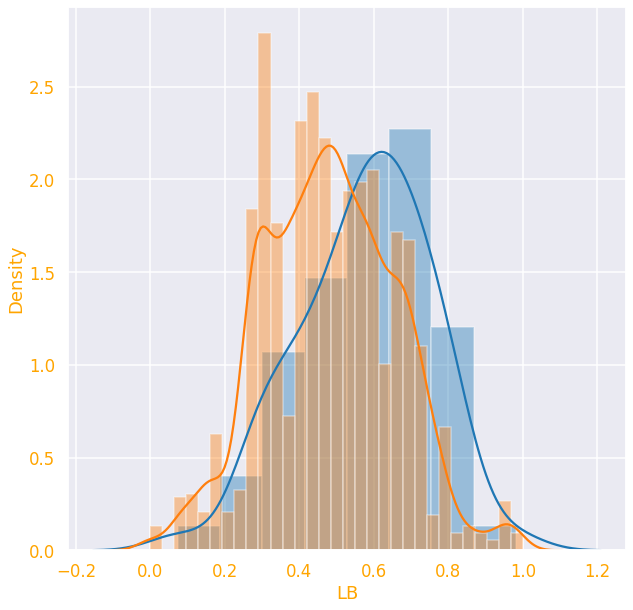

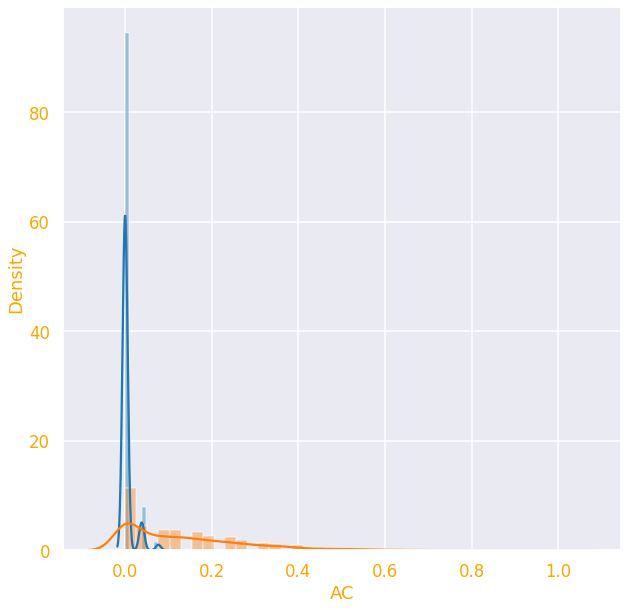

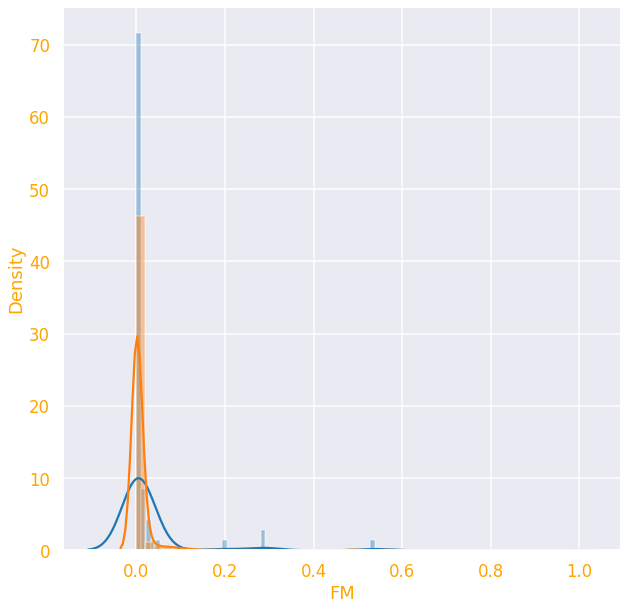

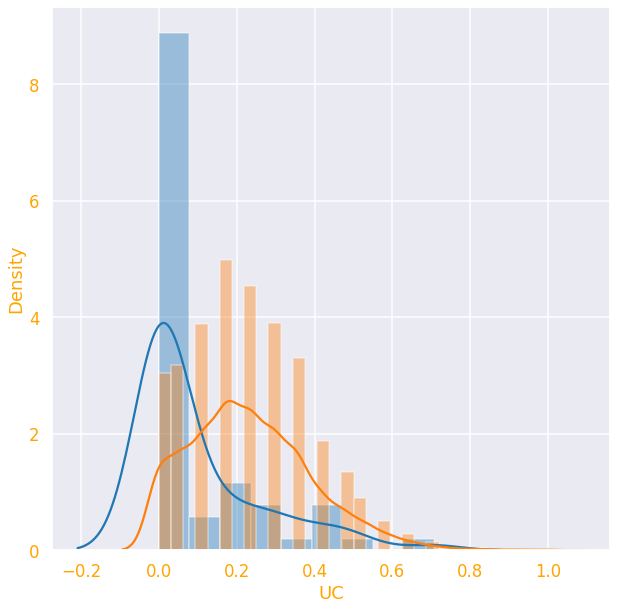

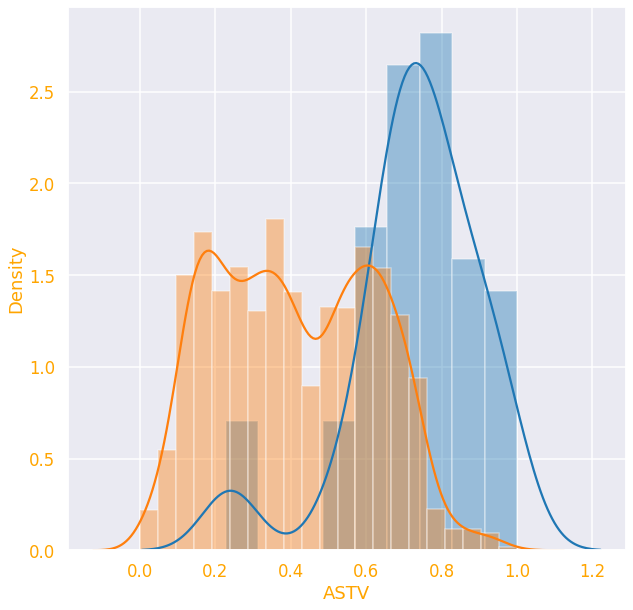

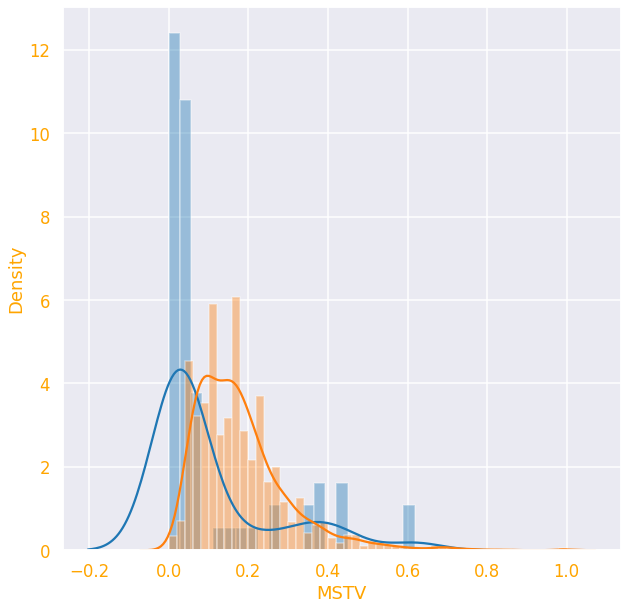

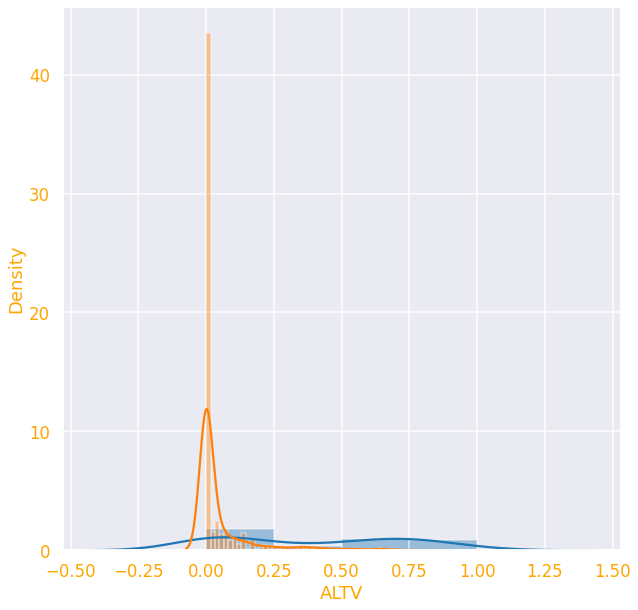

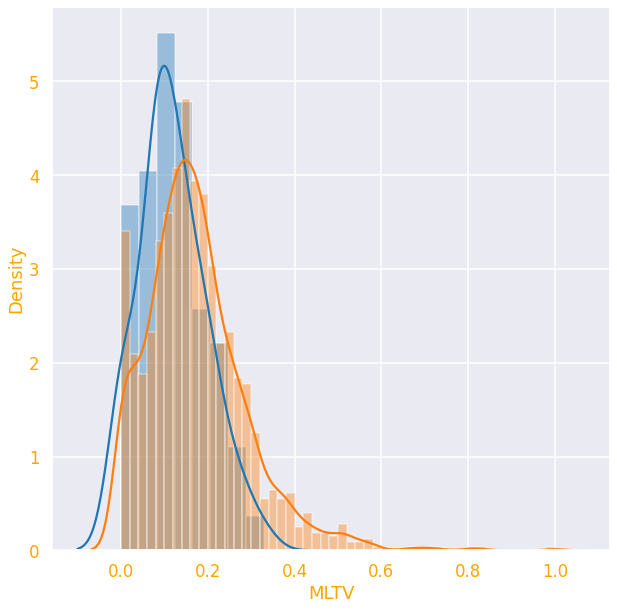

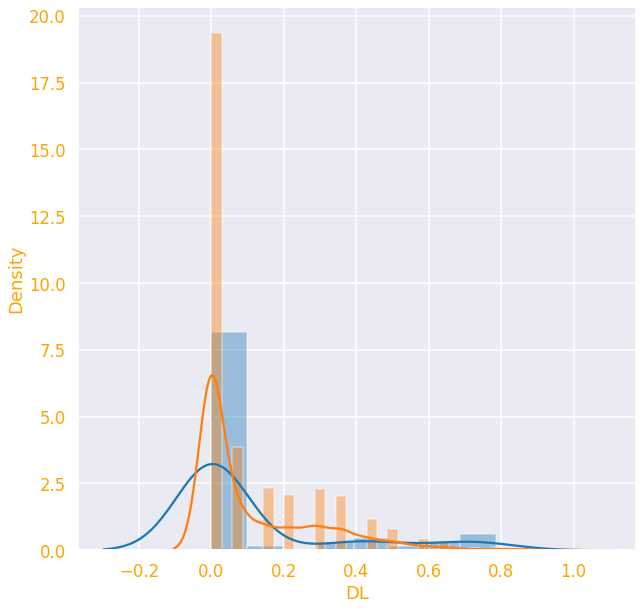

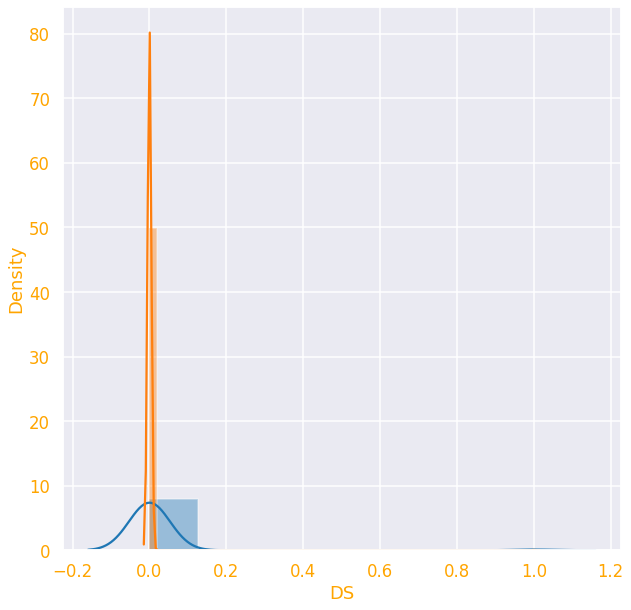

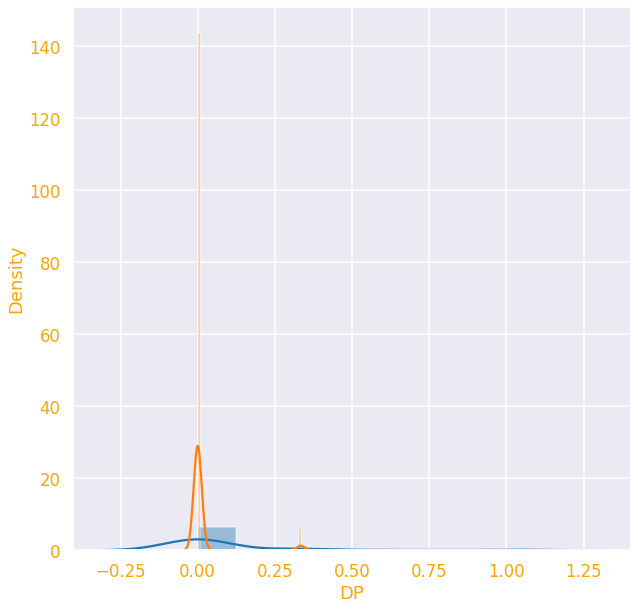

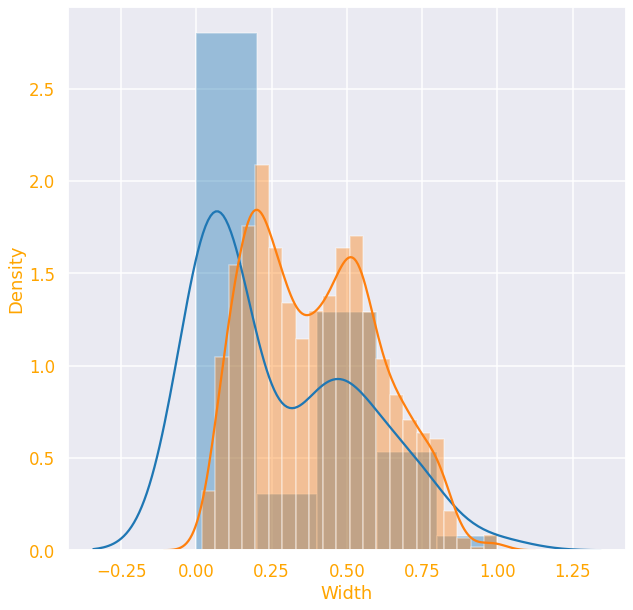

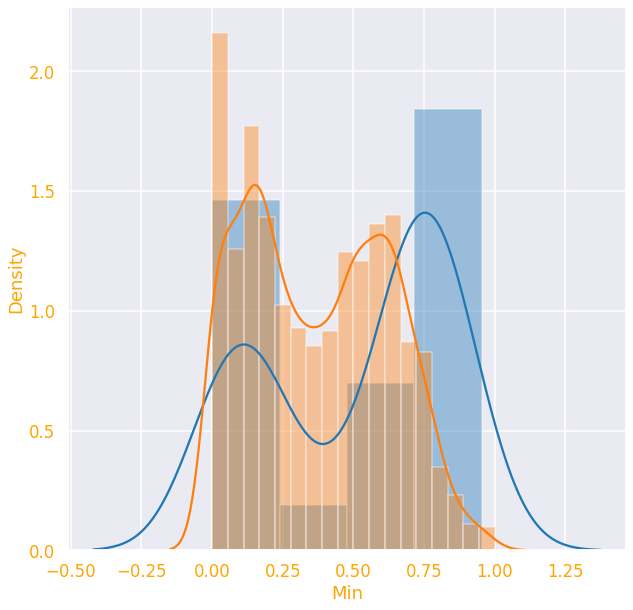

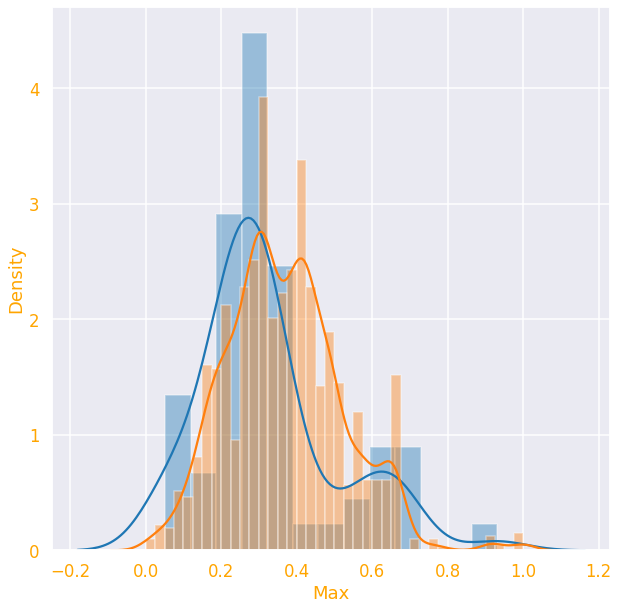

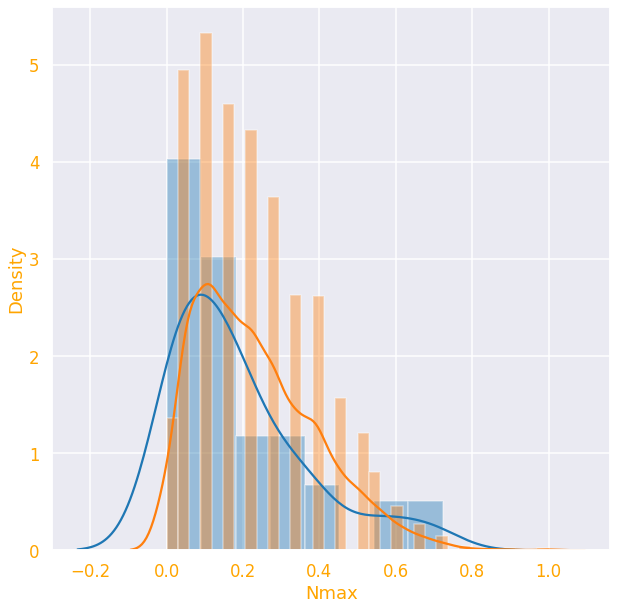

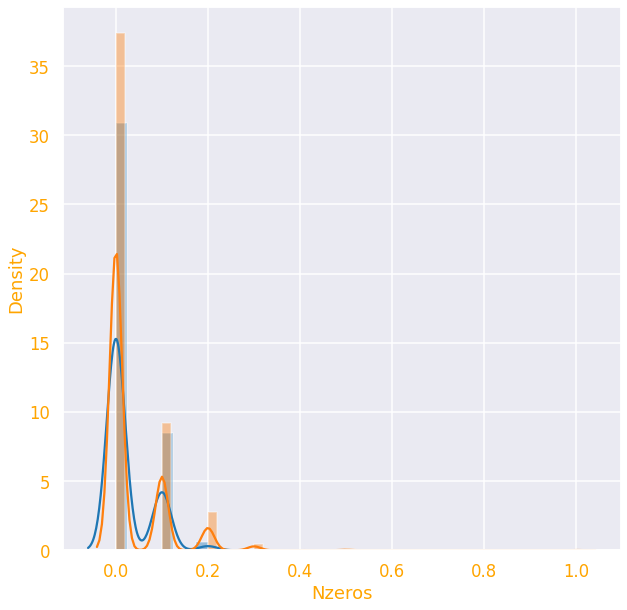

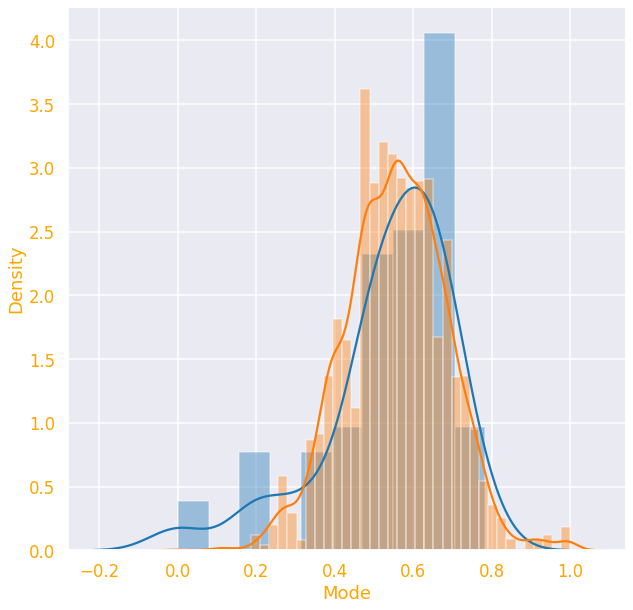

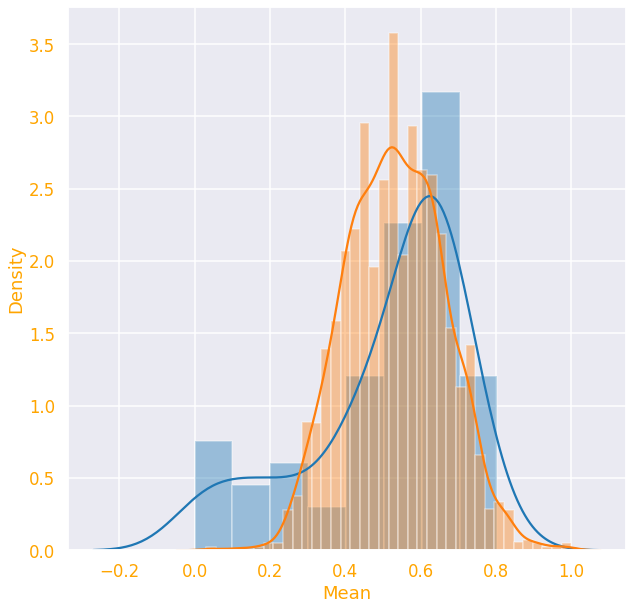

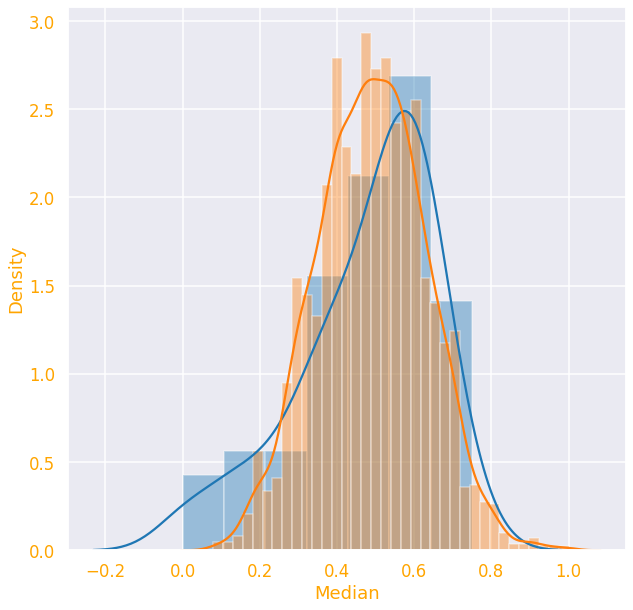

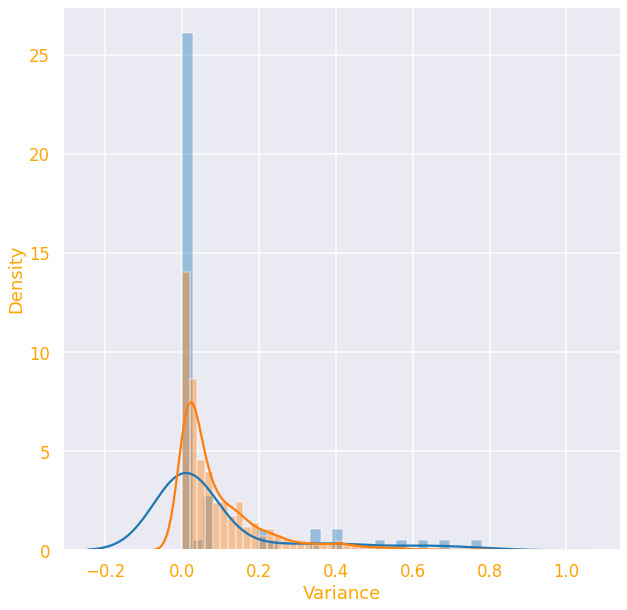

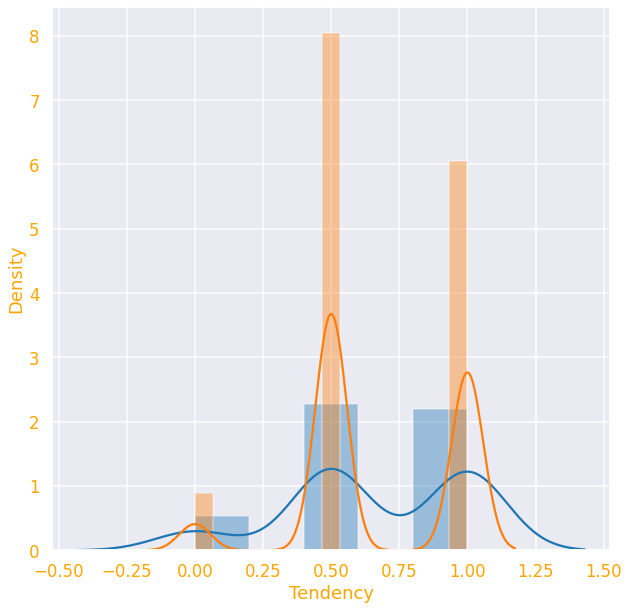

In [45]:
for feature in features:
    plt.figure()
    
    sns.distplot(df[df[target] == 1][feature] )
    sns.distplot(df[df[target] == 0][feature] )


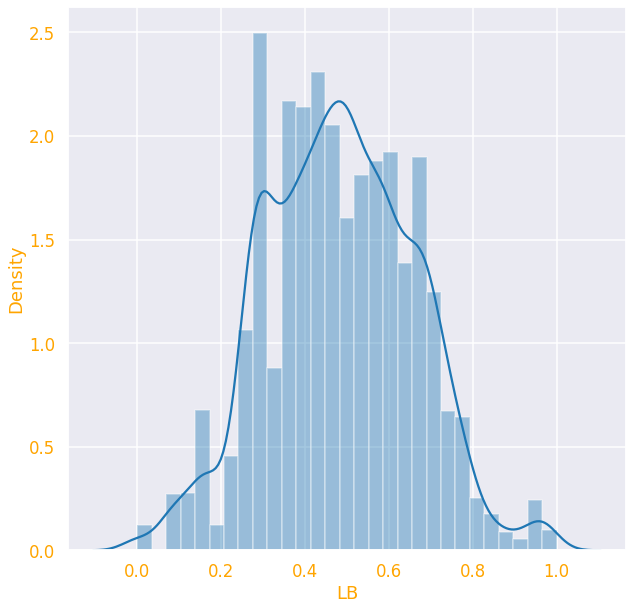

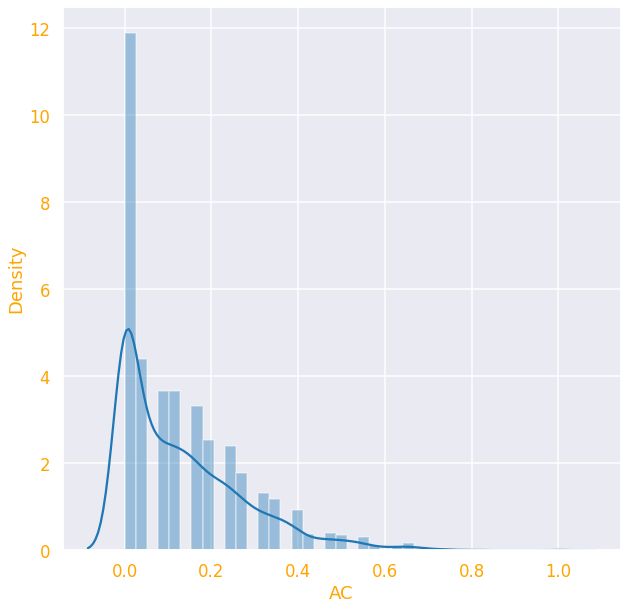

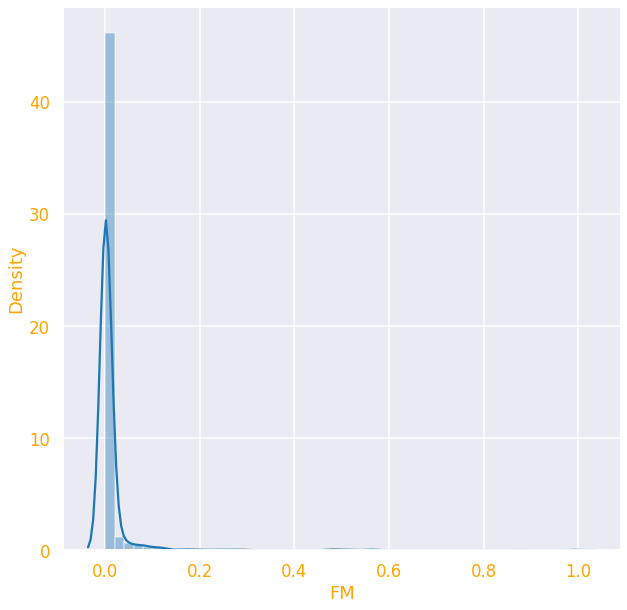

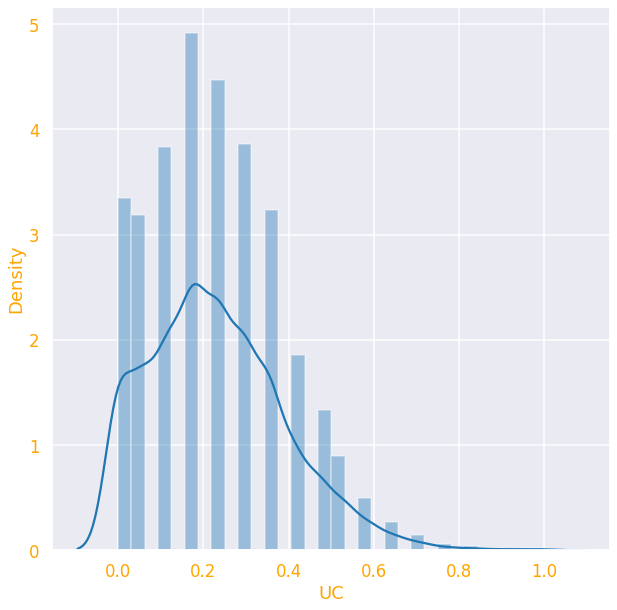

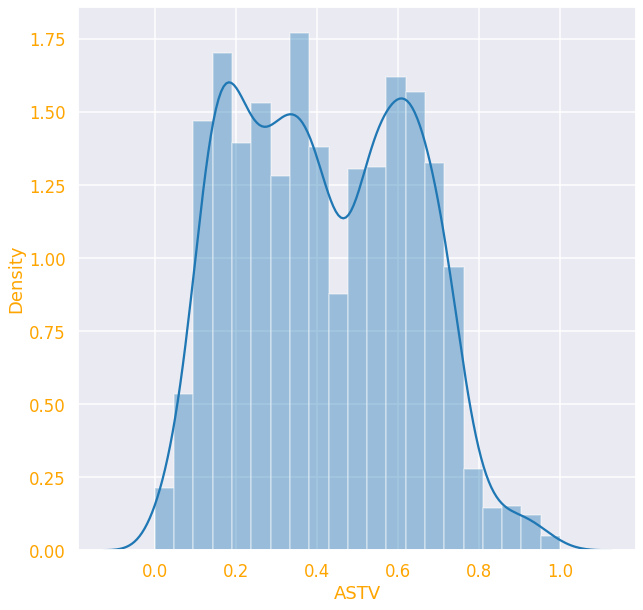

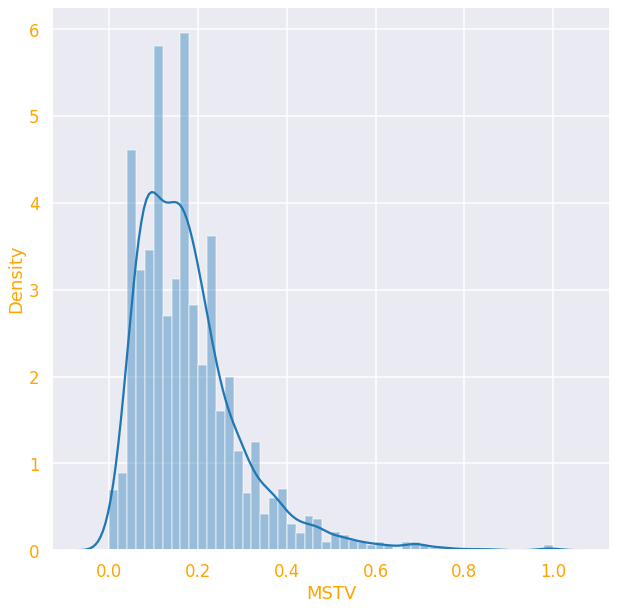

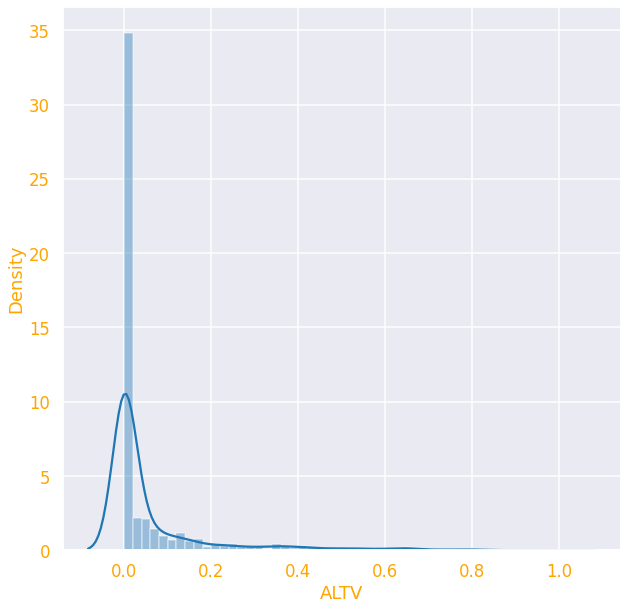

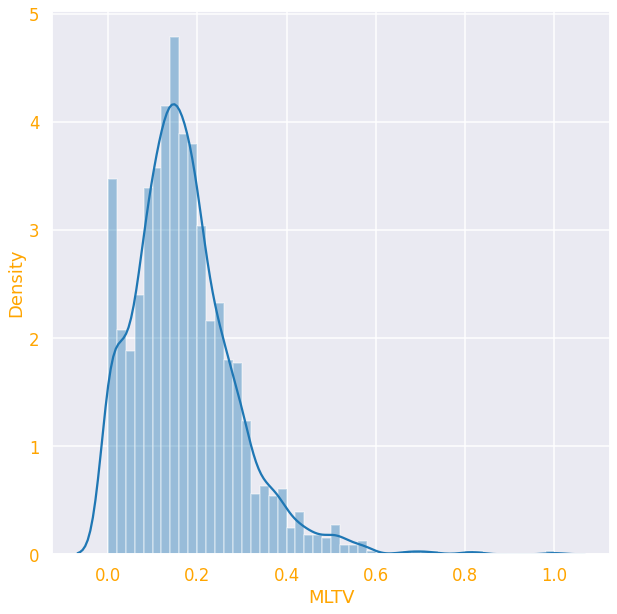

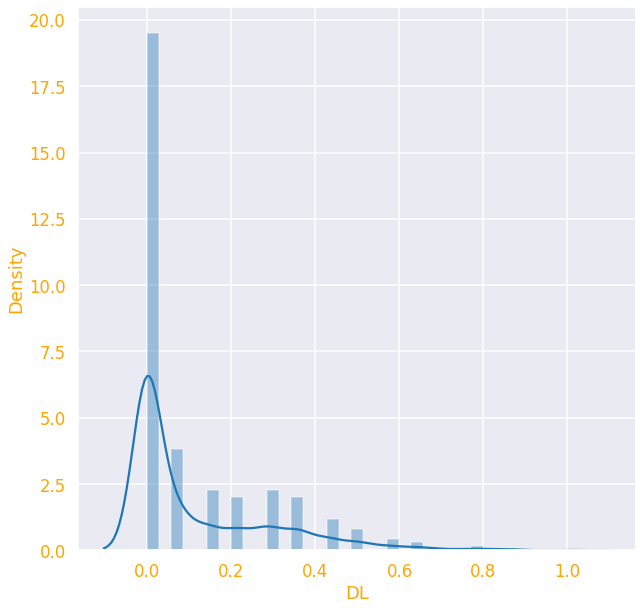

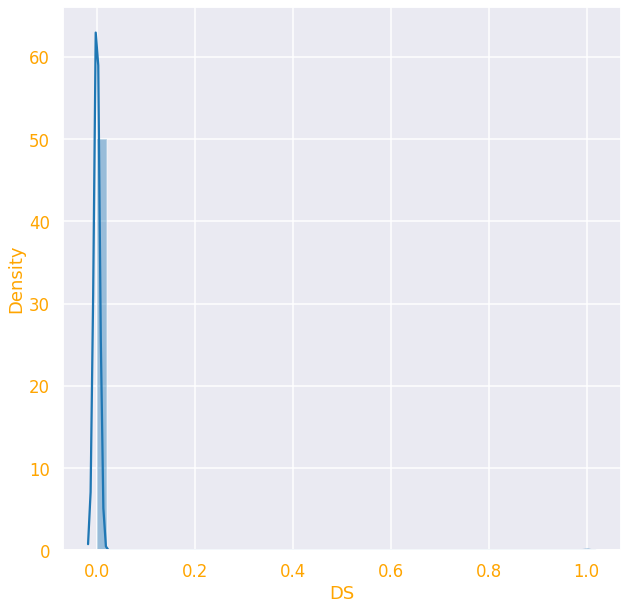

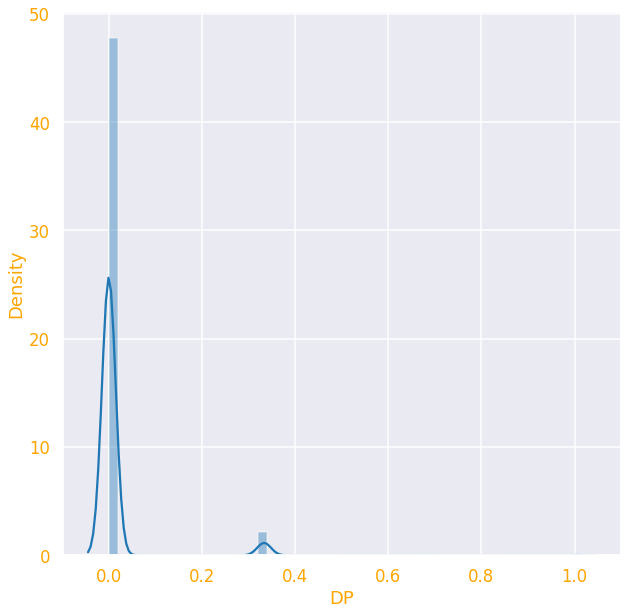

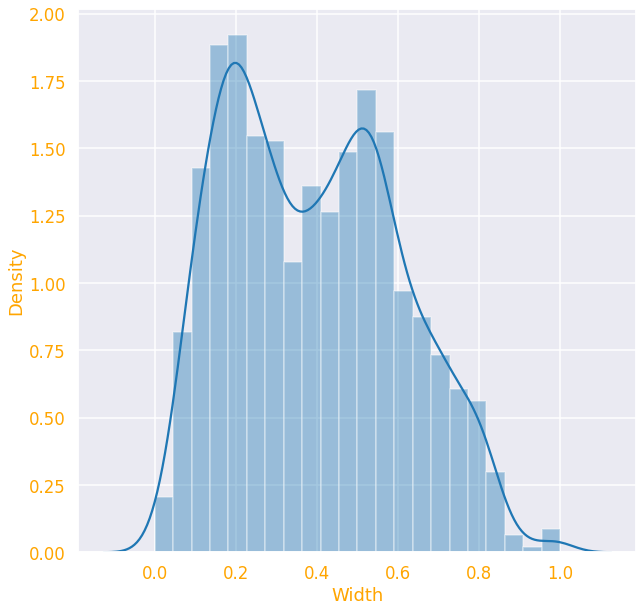

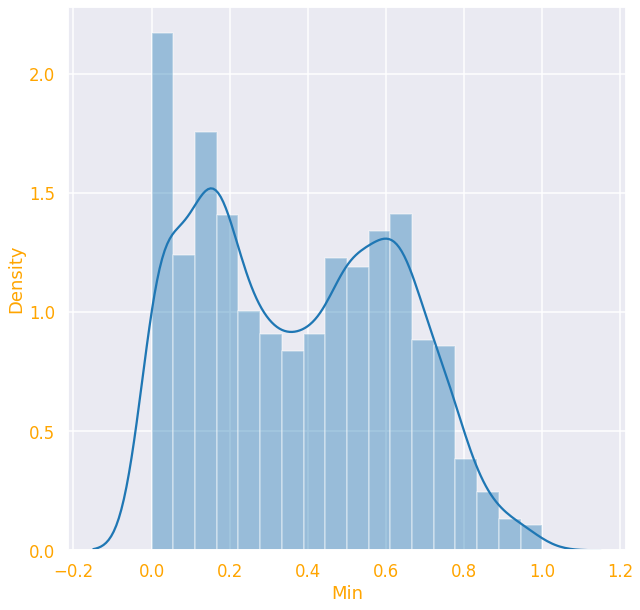

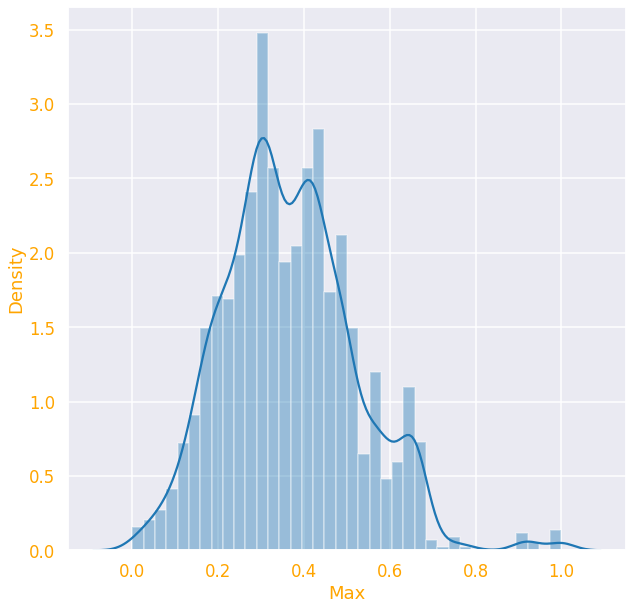

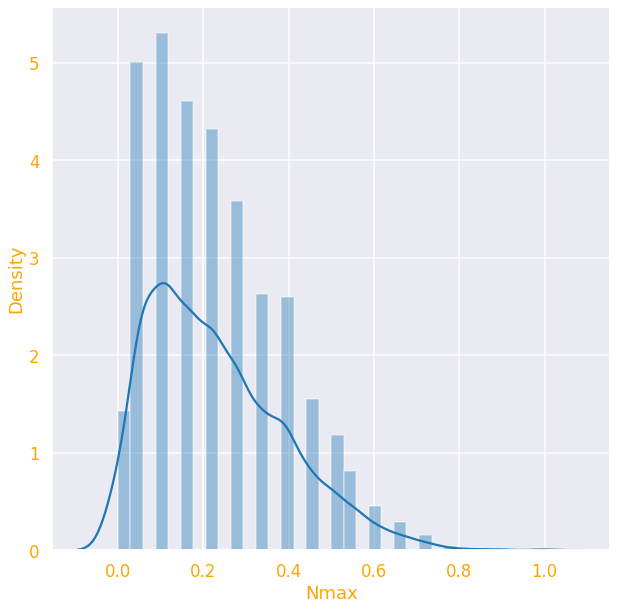

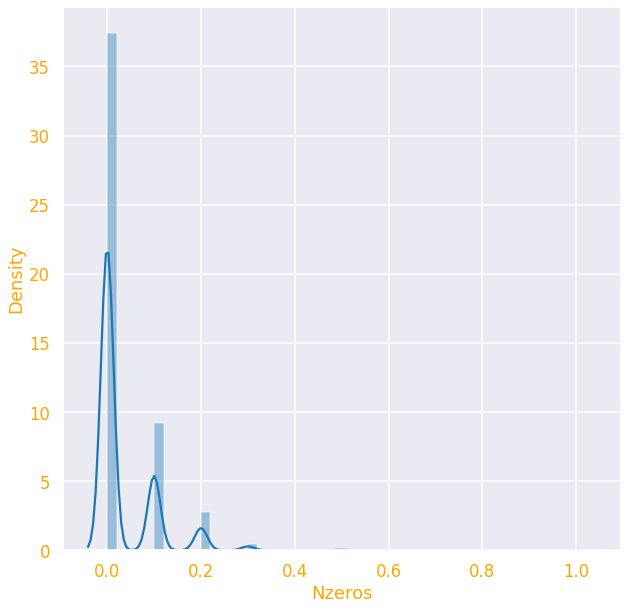

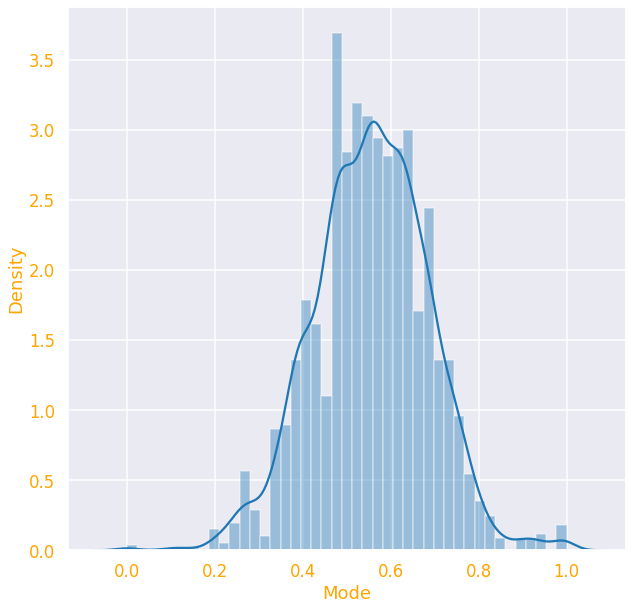

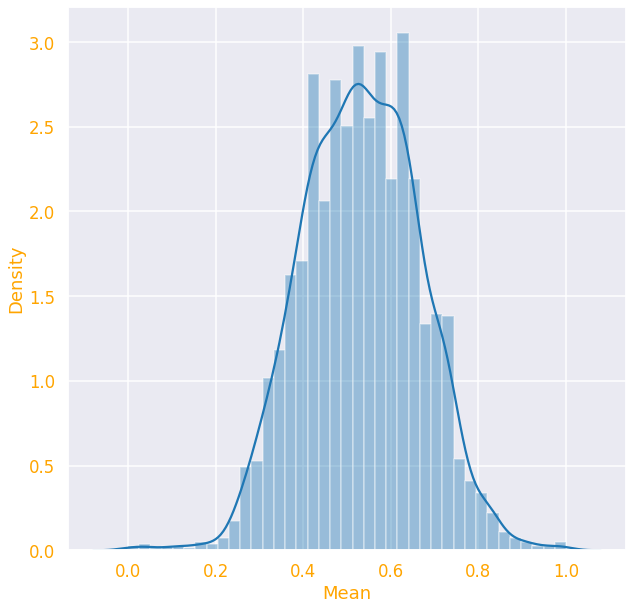

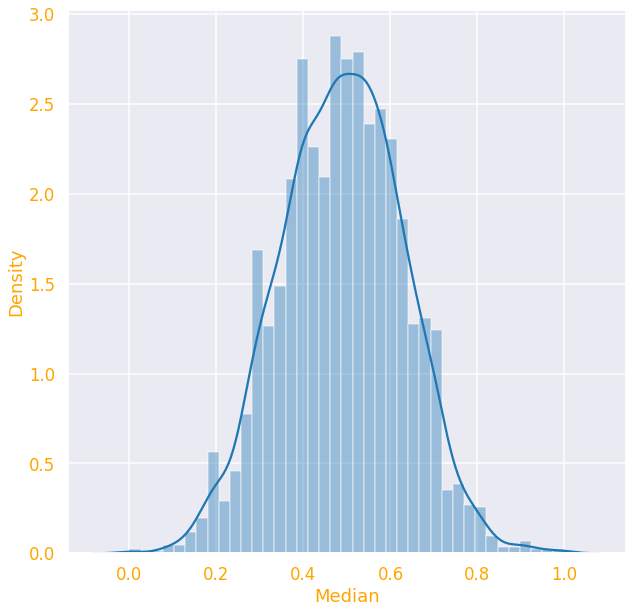

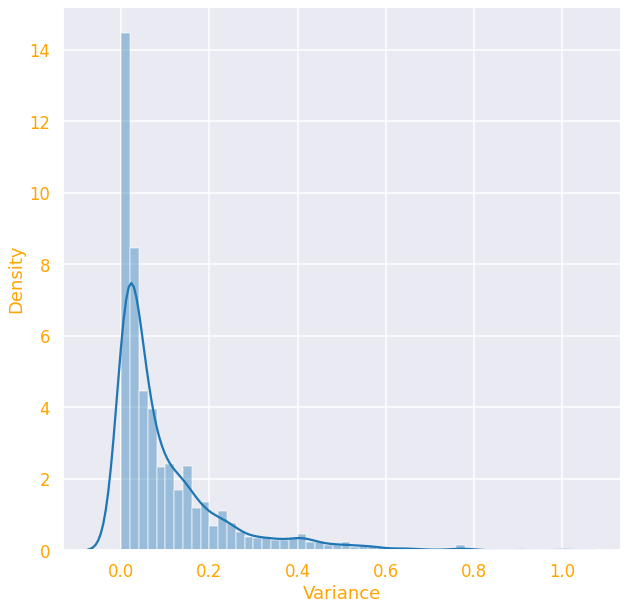

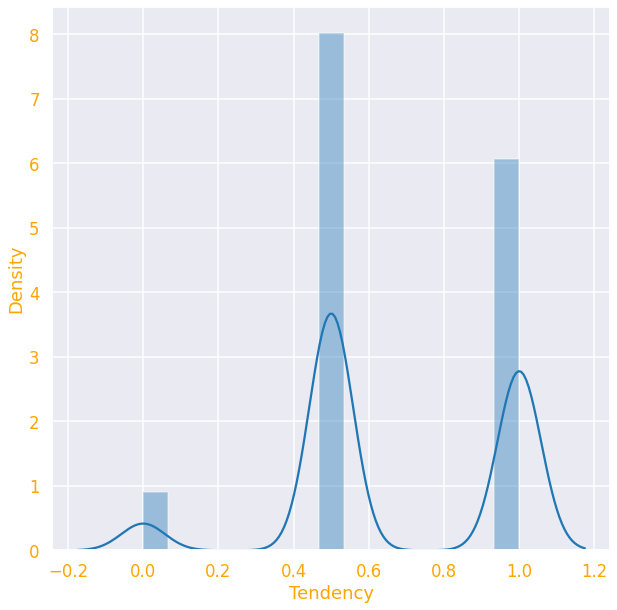

In [46]:
for feature in features:
    plt.figure()
    
    sns.distplot(df[feature] )


Data seems to be skewed for several features so we can apply sqrt transformation to handle it.


## 2.2. Add new features

In [47]:
df_sqrt = df[features].apply(lambda x: x.apply(lambda y: math.pow(y, 1/2)), axis=0)

for feature in features:
    df[str(feature) + '_sqrt'] = df_sqrt[feature]

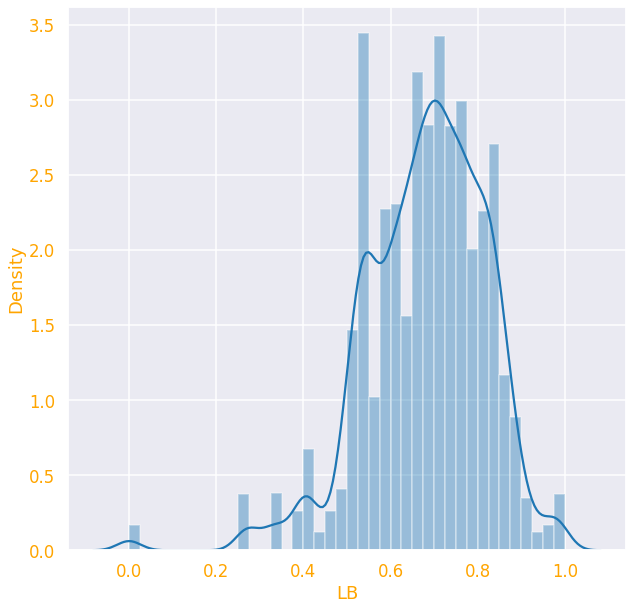

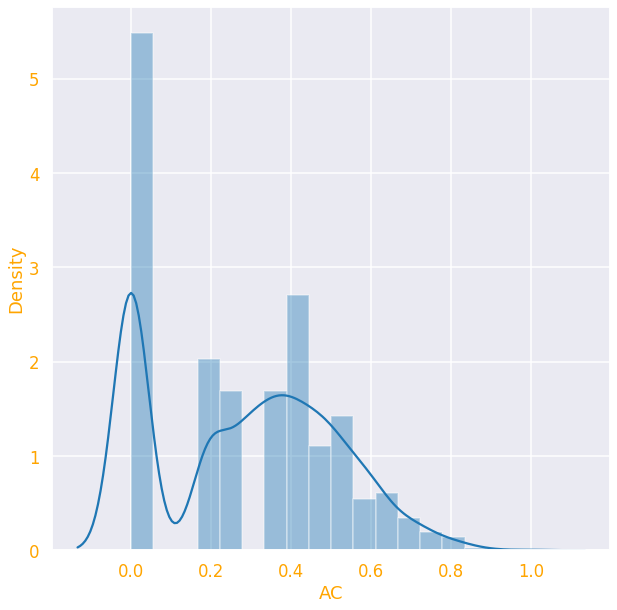

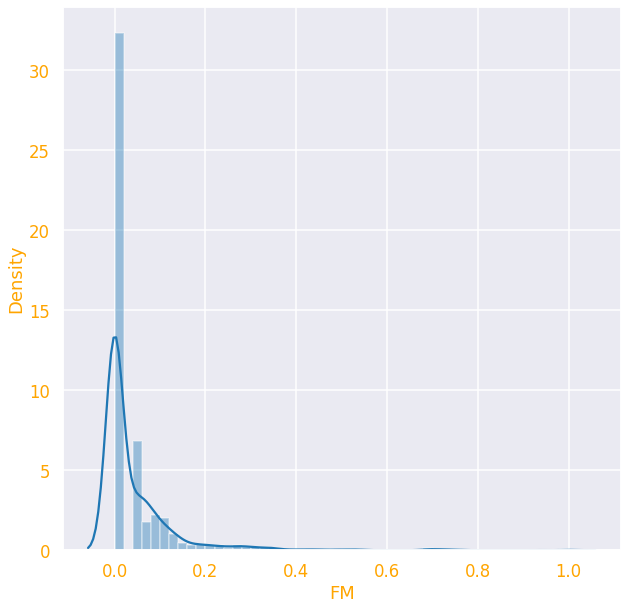

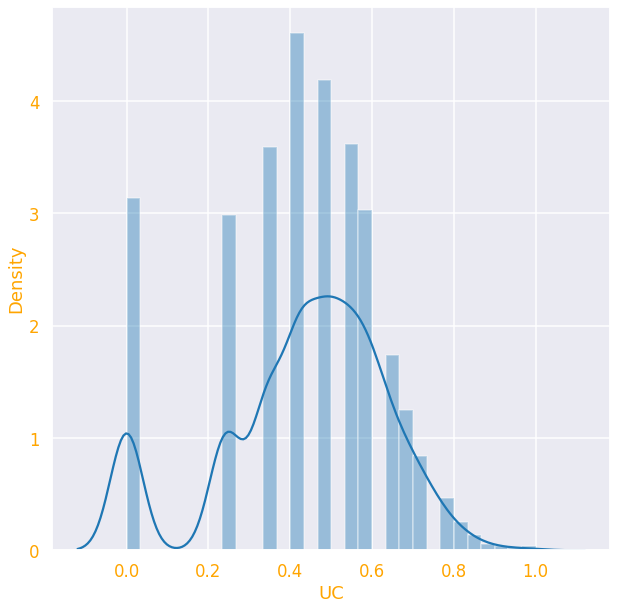

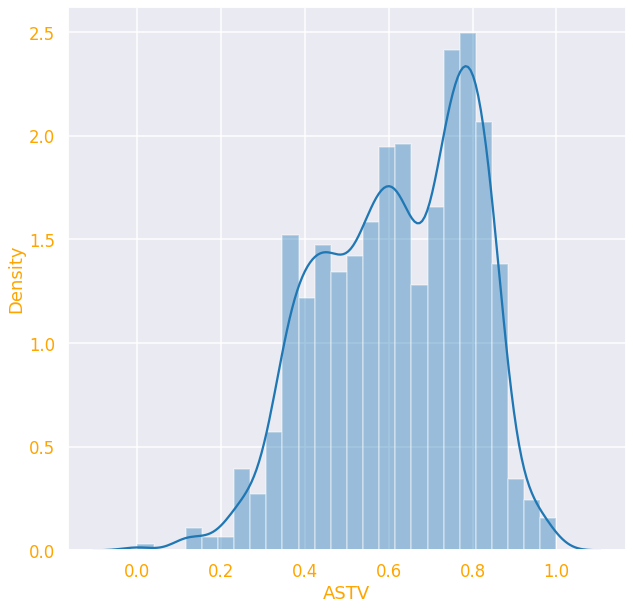

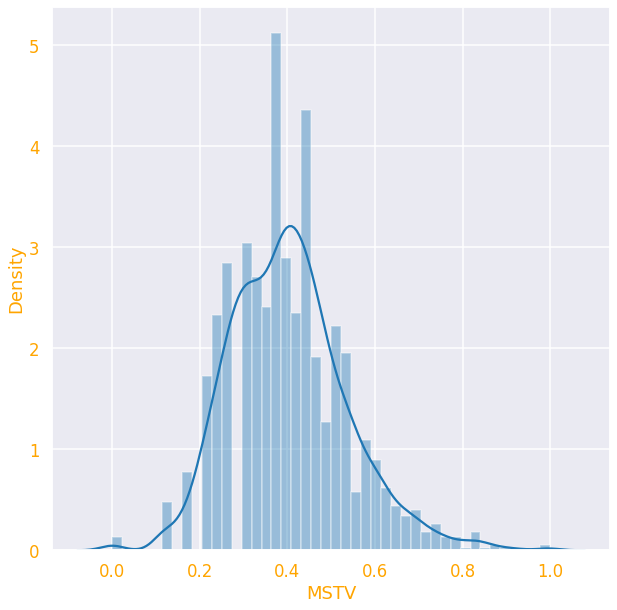

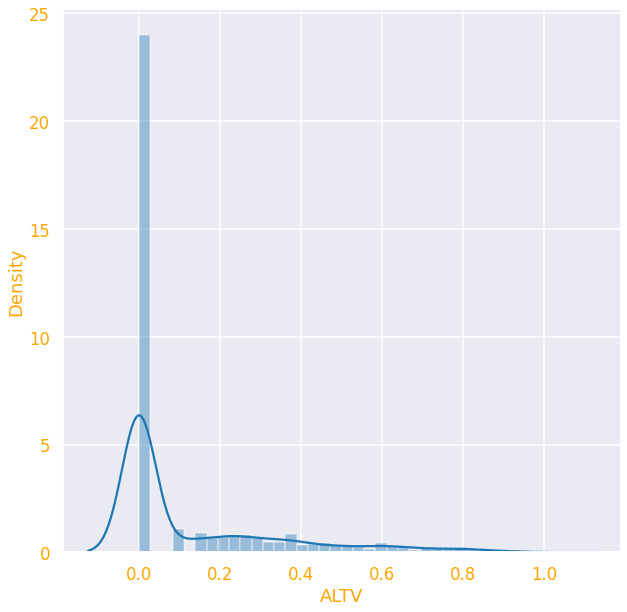

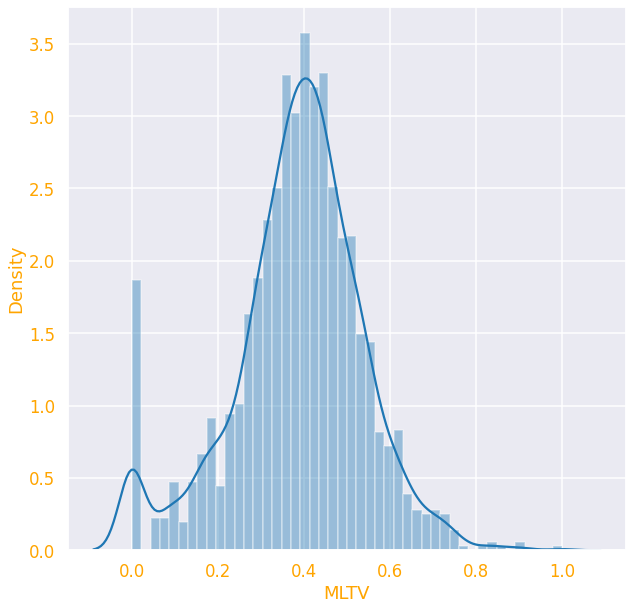

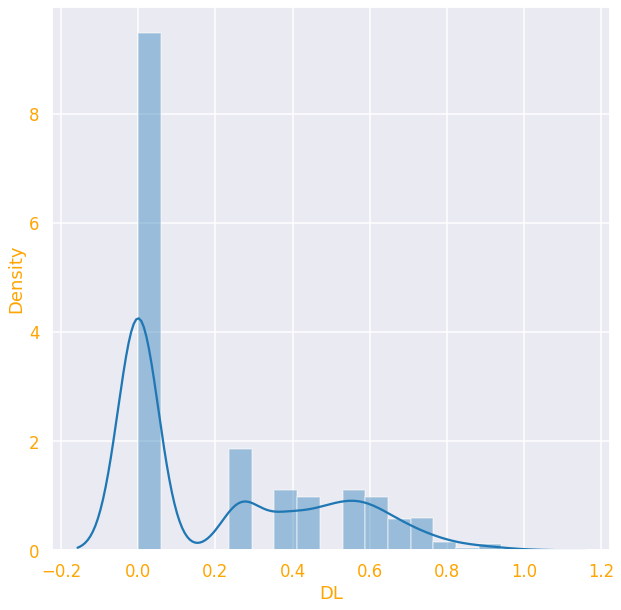

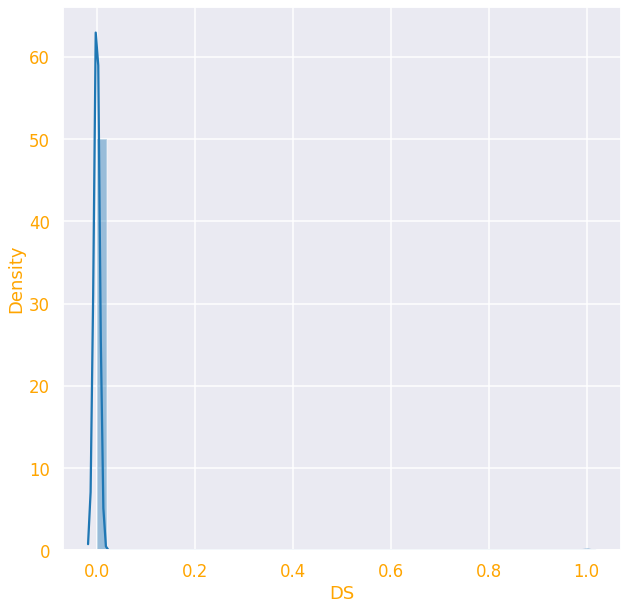

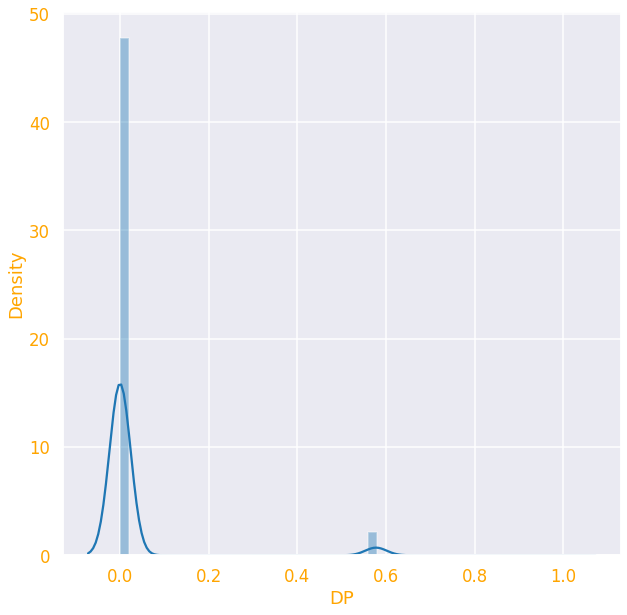

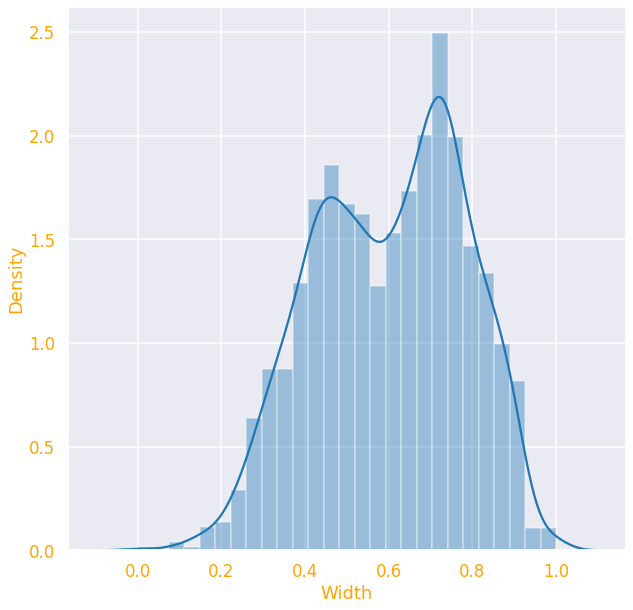

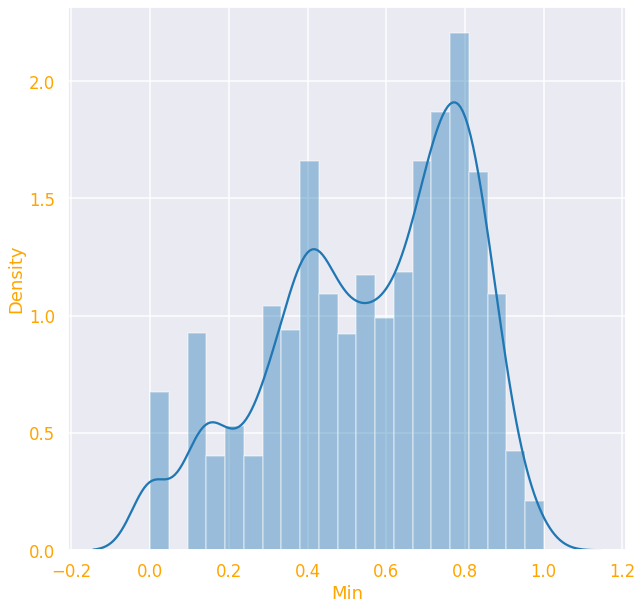

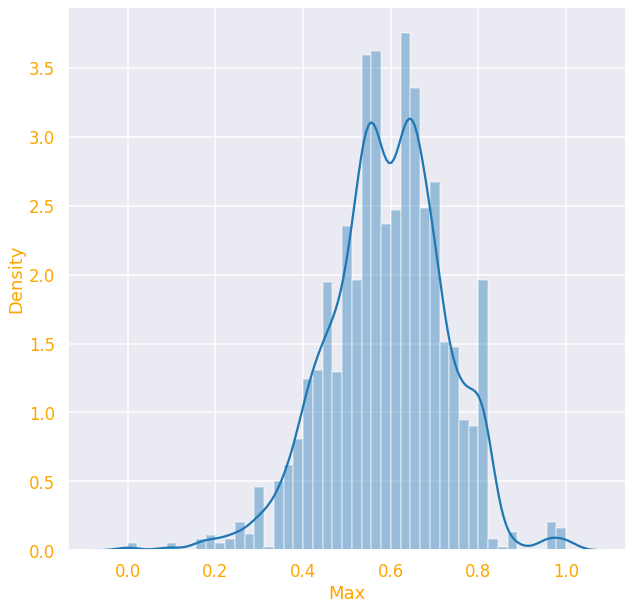

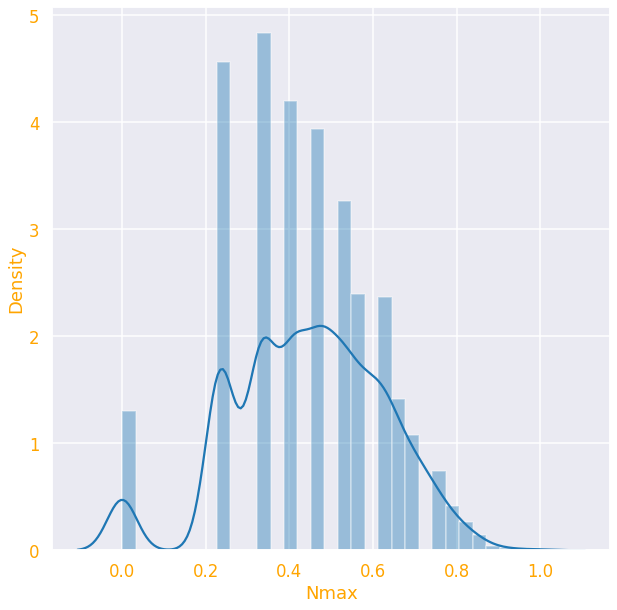

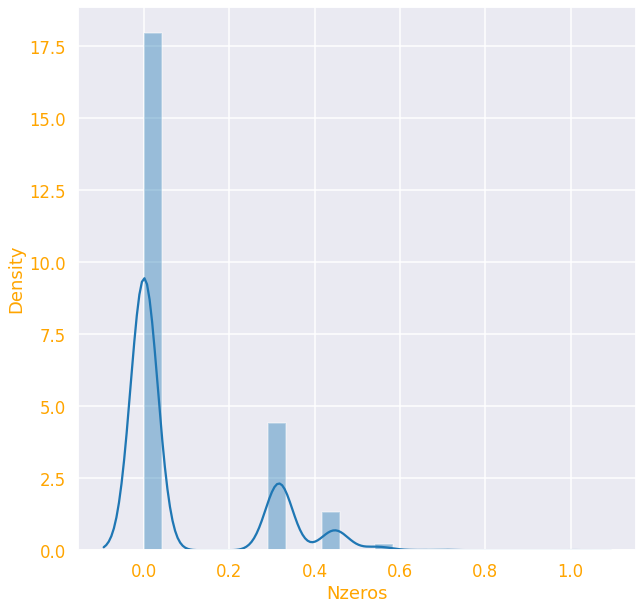

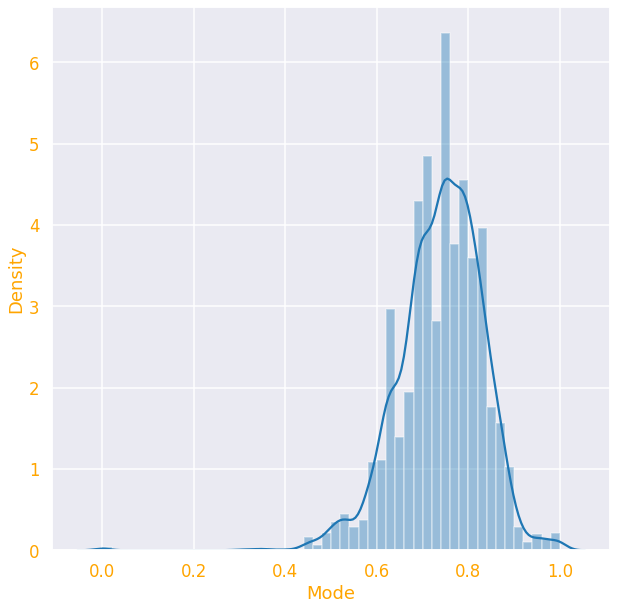

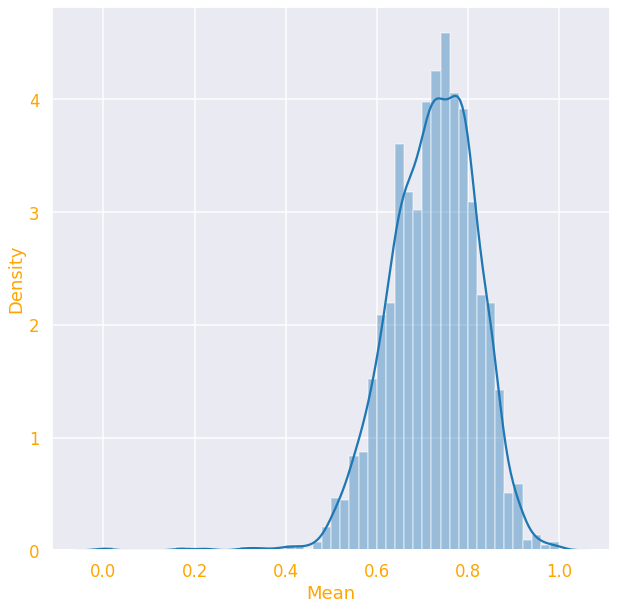

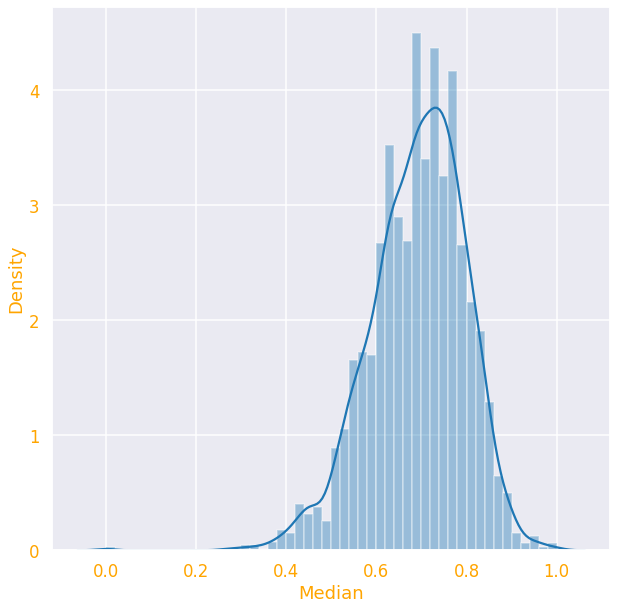

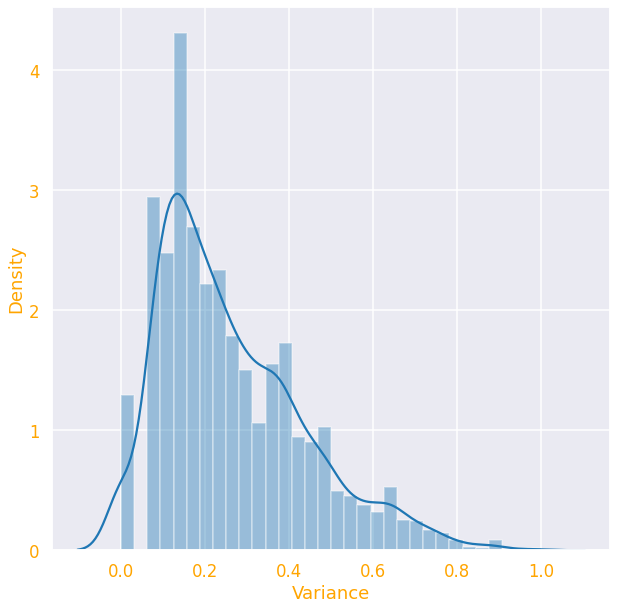

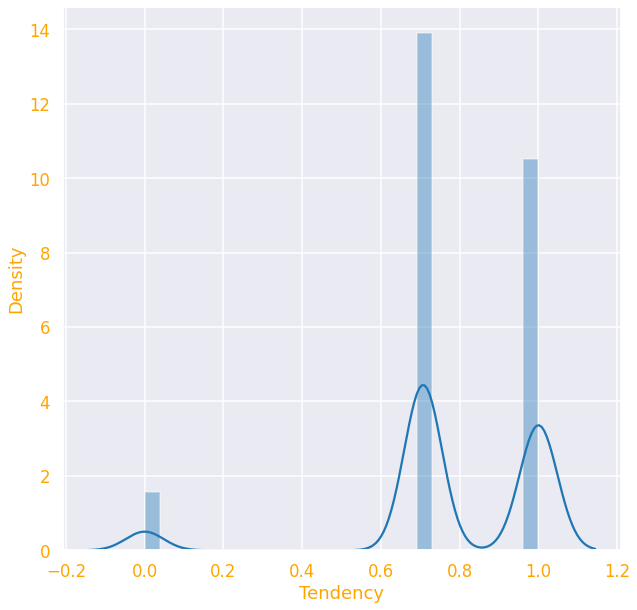

In [48]:
for feature in features:
    plt.figure()
    
    sns.distplot(df_sqrt[feature] )

Some of the features are close to normal distribution after sqrt transformation so it seems to be a good feature

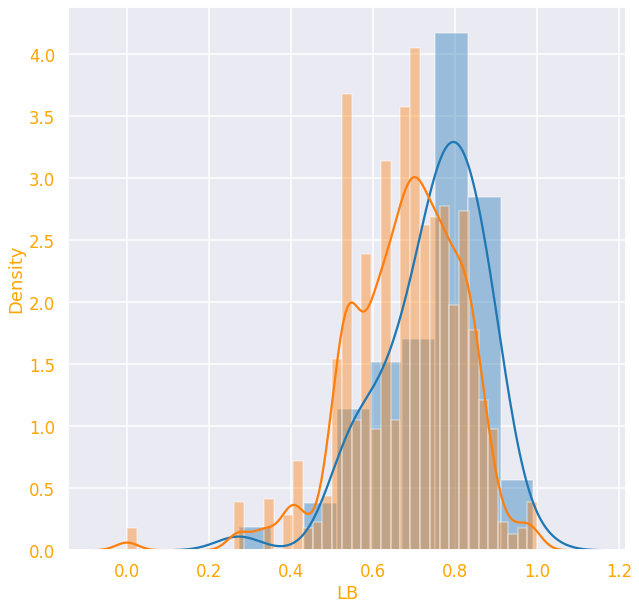

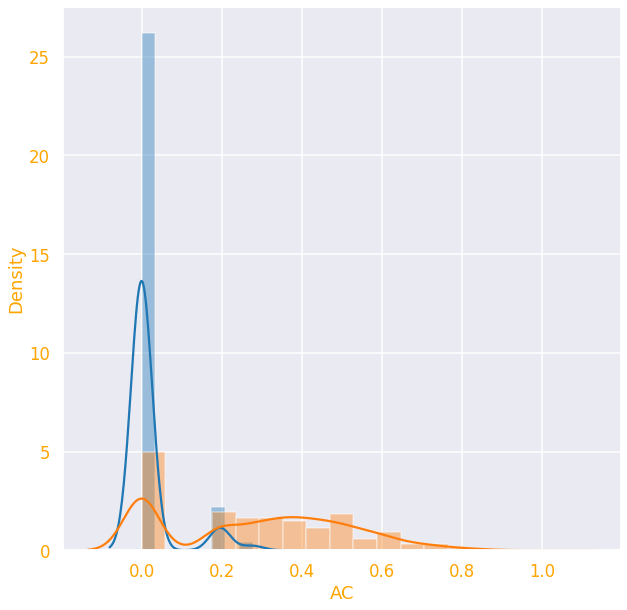

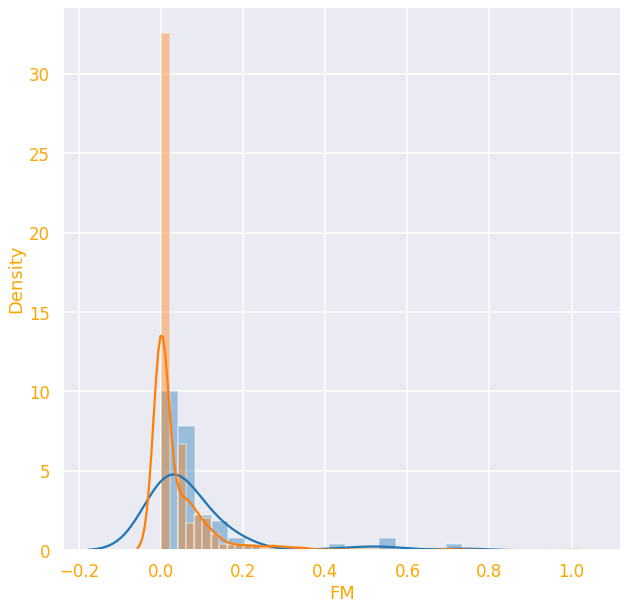

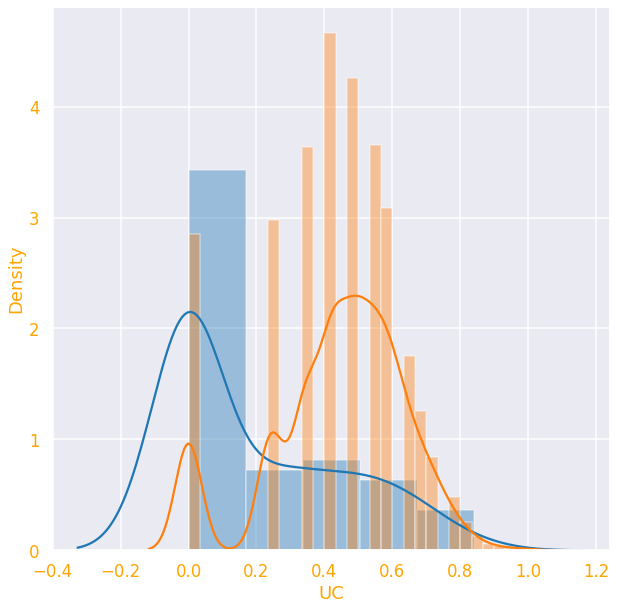

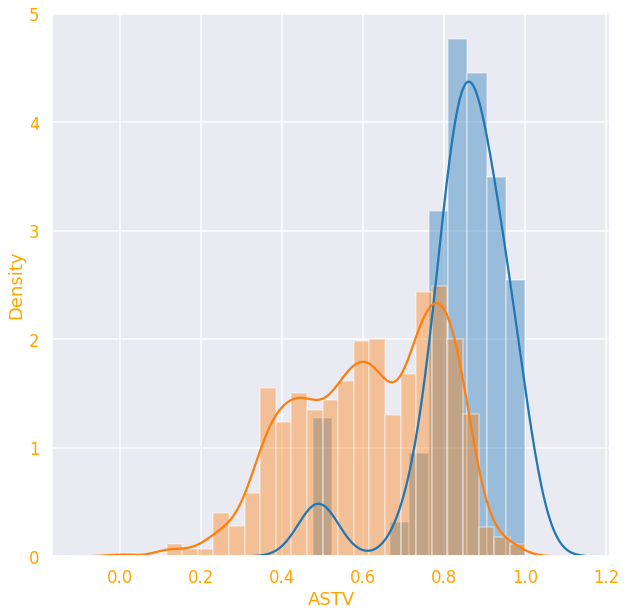

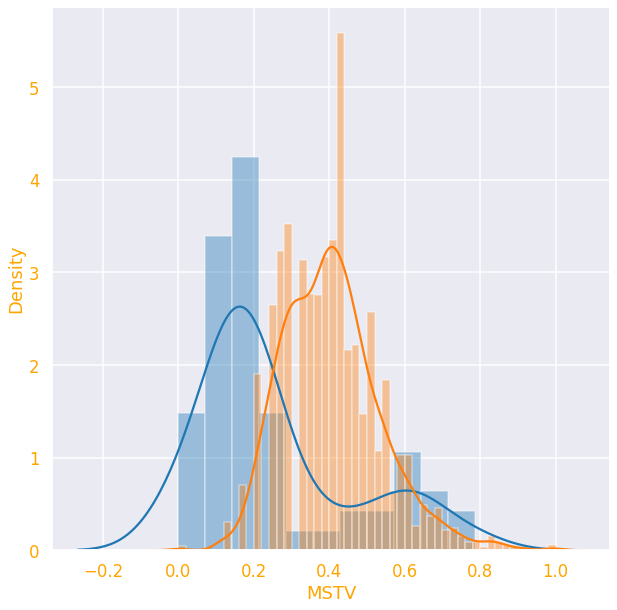

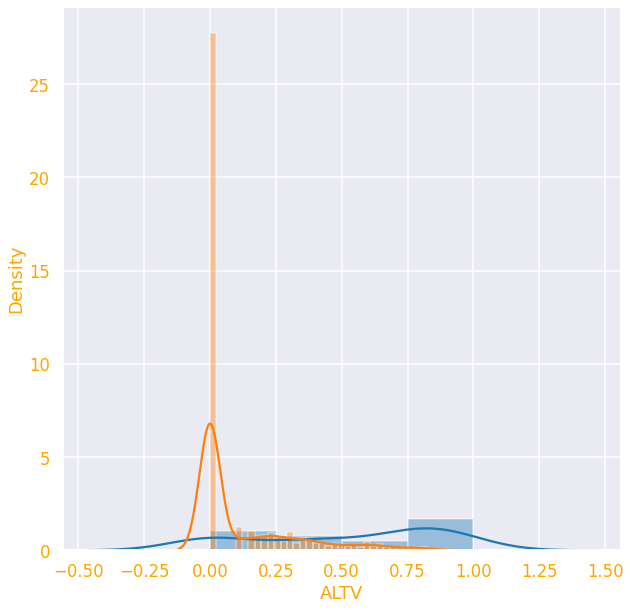

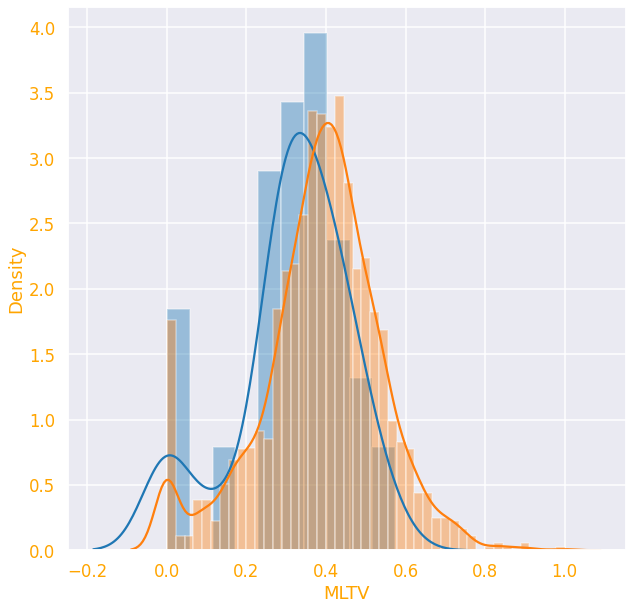

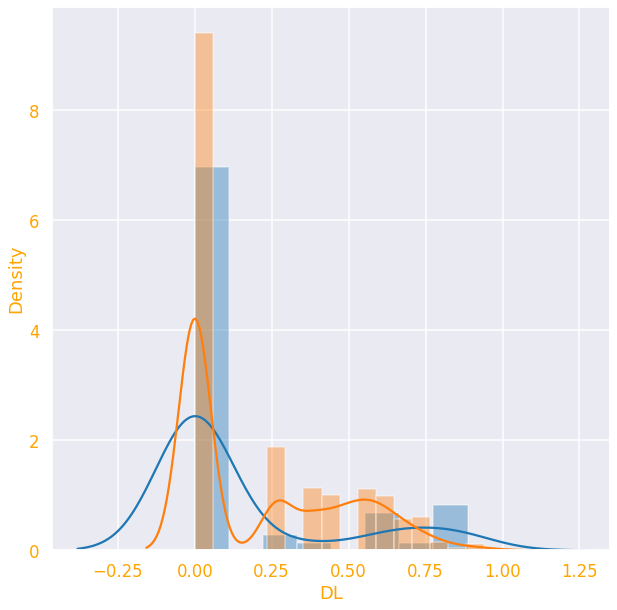

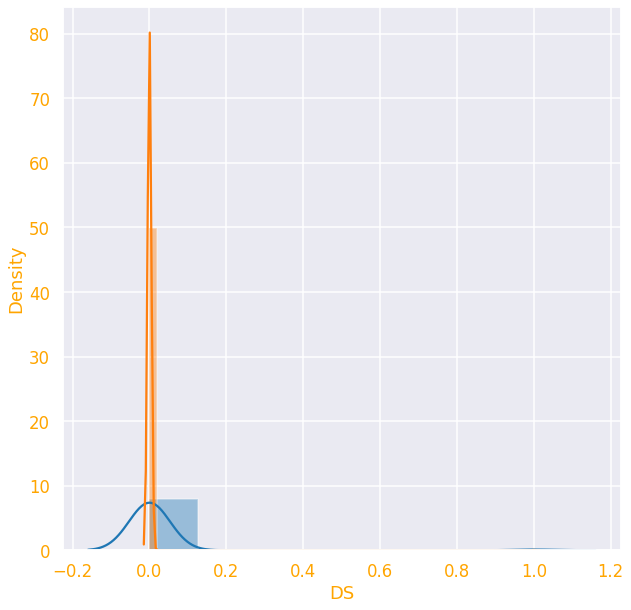

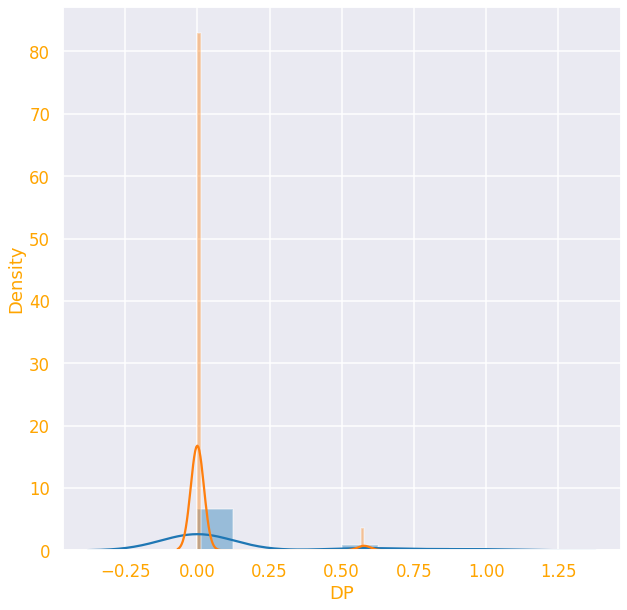

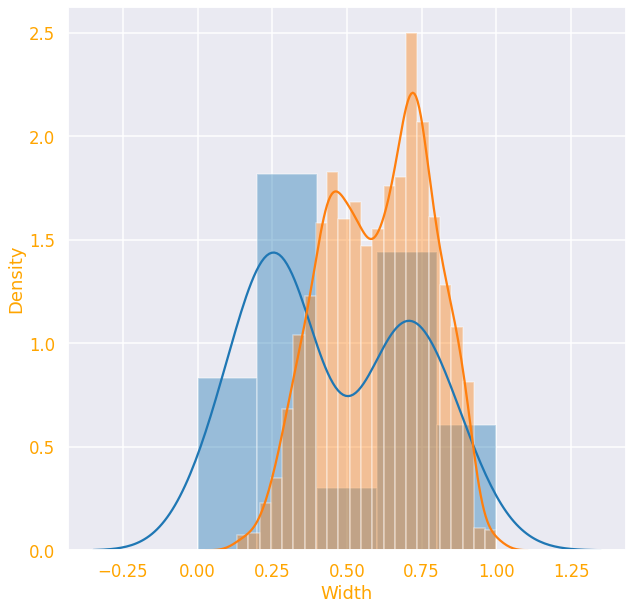

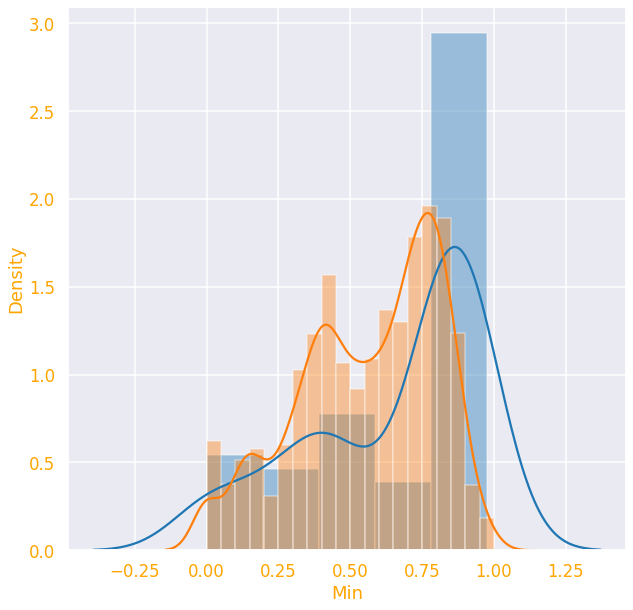

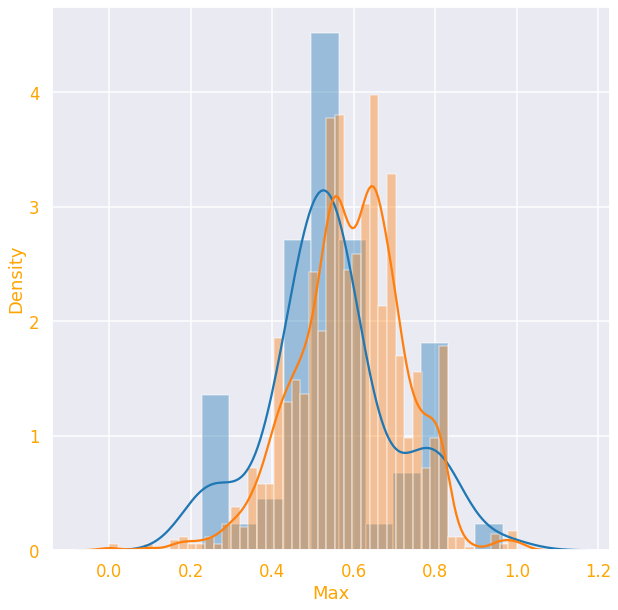

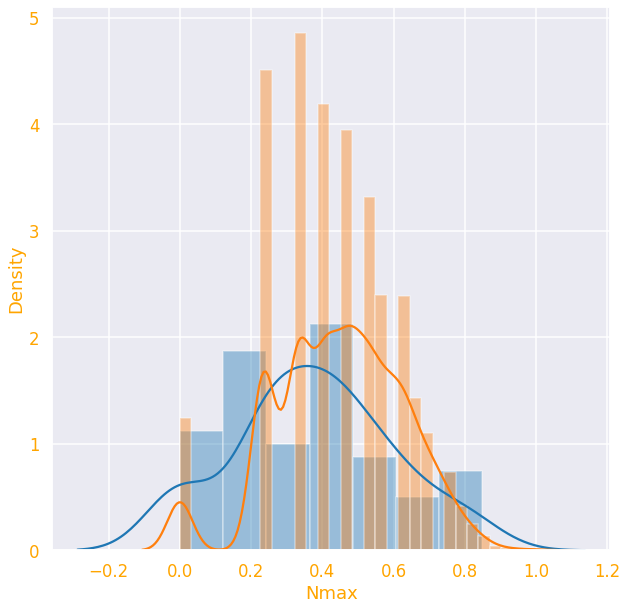

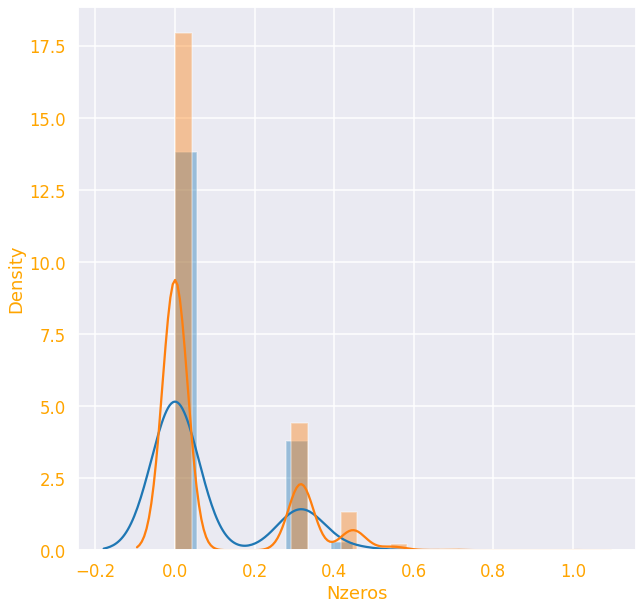

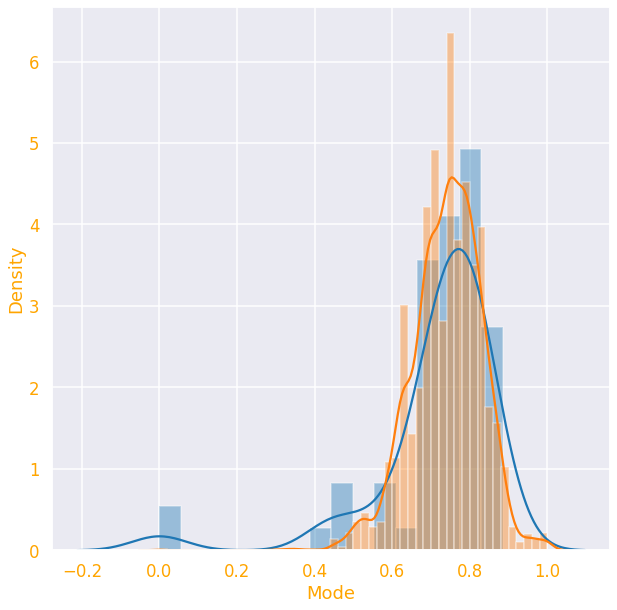

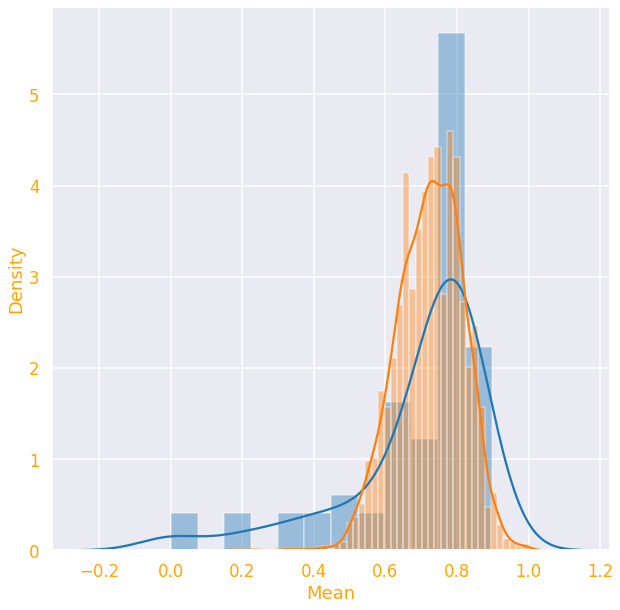

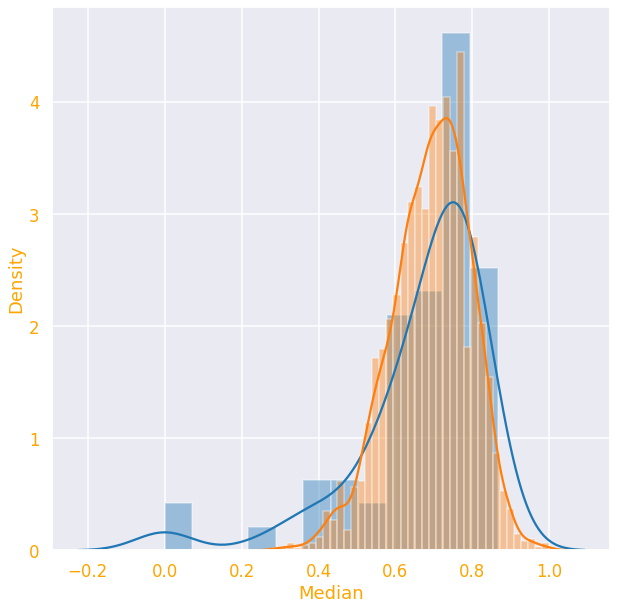

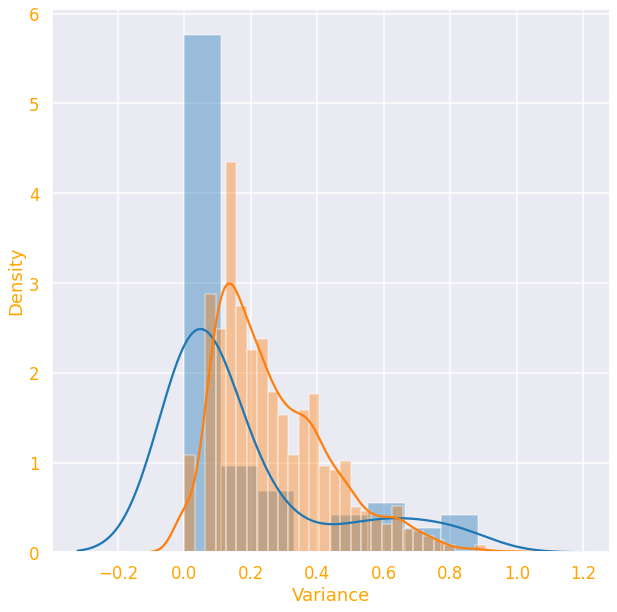

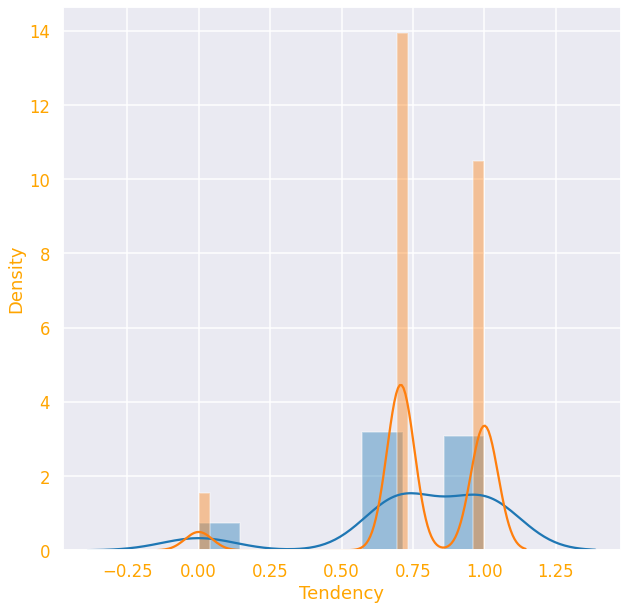

In [49]:
for feature in features:
    plt.figure()
    
    sns.distplot(df_sqrt[df[target] == 1][feature] )
    sns.distplot(df_sqrt[df[target] == 0][feature] )


In [50]:
all_transformed_features = list(df.columns)
all_transformed_features.remove(target)

In [51]:
data = df[all_transformed_features].values


# Train-test split

In [52]:
all_ids = np.unique(df.index)

In [53]:
train_ids, test_ids = train_test_split(all_ids,  test_size=0.2, shuffle = True, 
                                        random_state=random_state)

x_train = data[df.index.isin(train_ids),: ]
x_test = data[df.index.isin(test_ids),: ]

y_train = df.loc[train_ids, target]
y_test = df.loc[test_ids, target]

### Dimensionality reduction

In [54]:
n_components = 15

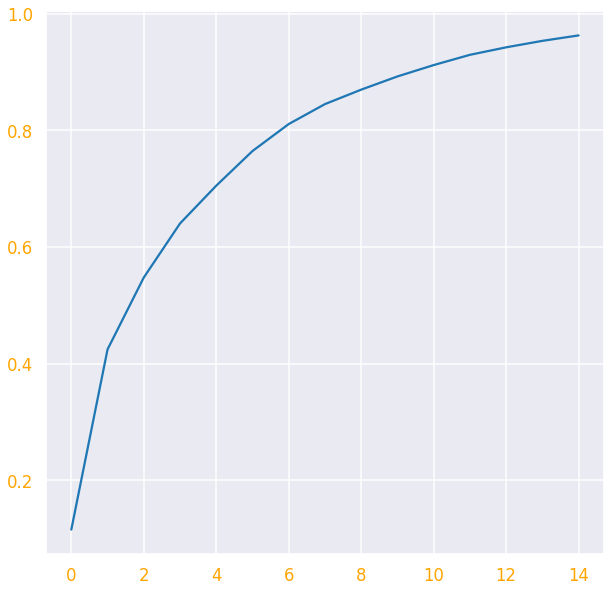

In [55]:
tsvd = TruncatedSVD(n_components=n_components)
tsvd.fit(x_train)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_));

In [56]:
print(sum(tsvd.explained_variance_ratio_))

0.9629596772422666


In [57]:
def normalize_l2(array):
    for row_id in range(array.shape[0]):
        array[row_id, :] = array[row_id, :] / np.linalg.norm(array[row_id, :])
    return array

In [58]:
train_svd = tsvd.fit_transform(x_train)

test_svd = tsvd.transform(x_test)


In [59]:
sum(train_svd[16,:] ** 2)

10.183730292214307

# Mahalanobis

In [60]:
def report_mahalanobis(
    x_train, x_test
):
    mean_vector = x_train.mean(axis=0)
    inv = np.linalg.inv(np.matmul(x_train.T, x_train))
    
    train_mahalanobis_score = np.zeros(x_train.shape[0])
    test_mahalanobis_score = np.zeros(x_test.shape[0])

    for row_id in range(x_train.shape[0]):
        train_mahalanobis_score[row_id] = mahalanobis(mean_vector, x_train[row_id,:], inv)

    for row_id in range(x_test.shape[0]):
        test_mahalanobis_score[row_id] = mahalanobis(mean_vector, x_test[row_id,:], inv)
    
    plt.hist(test_mahalanobis_score[y_test == 1], density=True, alpha=0.5)
    plt.hist(test_mahalanobis_score[y_test == 0], density=True, alpha=0.5)
    plt.title('Test hist')
    return train_mahalanobis_score, test_mahalanobis_score

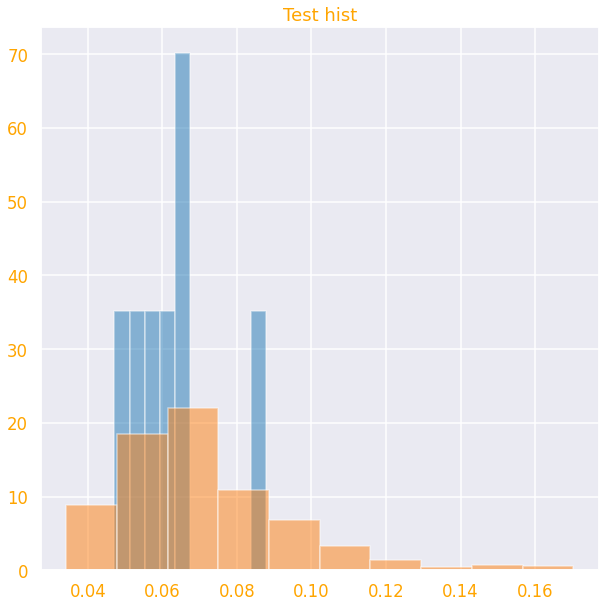

In [61]:
train_mahalanobis_score, test_mahalanobis_score = report_mahalanobis(
    train_svd, test_svd)

In [62]:
roc_auc_score(y_test, test_mahalanobis_score)

0.40120663650075417

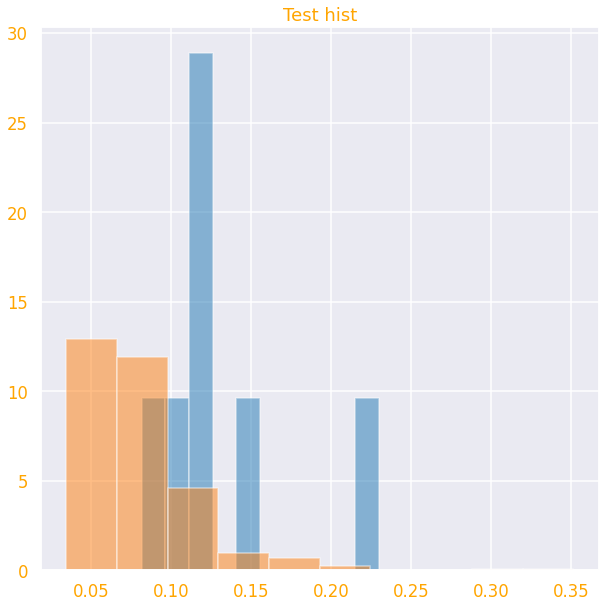

In [63]:
train_mahalanobis_score, test_mahalanobis_score = report_mahalanobis(
    df.loc[train_ids, features].values, df.loc[test_ids, features].values)

In [64]:
roc_auc_score(y_test, test_mahalanobis_score)

0.8758888170652877

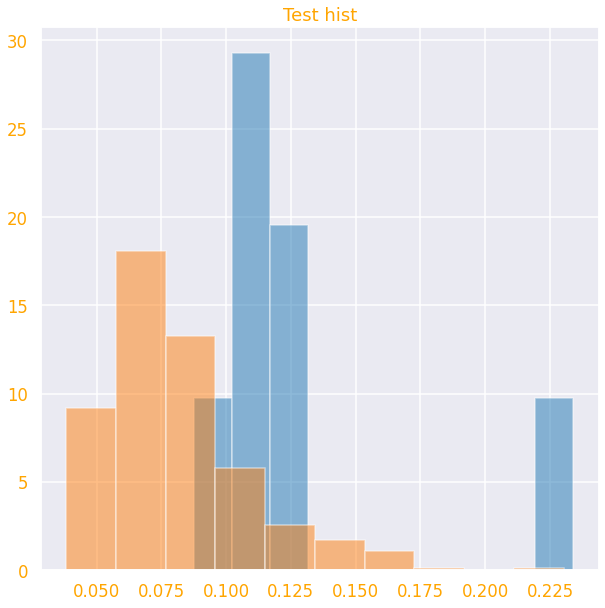

In [65]:
train_mahalanobis_score, test_mahalanobis_score = report_mahalanobis(
    df_sqrt.loc[train_ids].values, 
    df_sqrt.loc[test_ids].values)

In [66]:
test_mahalanobis_score

array([0.0604388 , 0.06244545, 0.0422647 , 0.05607402, 0.08374691,
       0.08026367, 0.05000125, 0.05437091, 0.09847713, 0.1011821 ,
       0.0890391 , 0.0884063 , 0.06507487, 0.06590461, 0.16261241,
       0.15512346, 0.11592747, 0.11243529, 0.12153853, 0.11689914,
       0.07709982, 0.09124293, 0.07312202, 0.07044652, 0.06830632,
       0.06481227, 0.07228876, 0.07420063, 0.0800296 , 0.07912044,
       0.1013038 , 0.10018487, 0.11180924, 0.11207157, 0.05686669,
       0.05912908, 0.11391866, 0.11397099, 0.04256925, 0.04290266,
       0.05392429, 0.05481382, 0.09831007, 0.09692826, 0.09875255,
       0.09613101, 0.07945336, 0.08004813, 0.07121587, 0.06893019,
       0.04525864, 0.05206822, 0.10434396, 0.08627484, 0.05487355,
       0.06008394, 0.0736937 , 0.06264245, 0.06594662, 0.08048311,
       0.07884997, 0.07892832, 0.12743086, 0.12670421, 0.07491336,
       0.07784013, 0.07945018, 0.07761744, 0.06699629, 0.06606133,
       0.06018244, 0.06567808, 0.06658884, 0.06663857, 0.08425

In [67]:
roc_auc_score(y_test, test_mahalanobis_score)

0.8608058608058609

SVD transformation seems to be useless, maybe have to change something.
Sqrt features slightly imroves test metric

# 3. Supervised algorithms



Outlier detection can be considered as imbalanced classificaiton problem if data is labeled. 
In this work we will try Logreg, SVM and KNN as base models.
Metrics to check:
    1) Precision/Recall - to understand model balance between 1-st and 2-nd error types
    2) Precision-recall AUC - to estimate over
    3) ROC-AUC - to estimate overall classification quality

In [68]:
supervised_results = pd.DataFrame(index=[
    'train_roc_auc',
    'train_pr_auc',
    'train_precision',
    'train_recall',
    'test_roc_auc',
    'test_pr_auc',
    'test_precision',
    'test_recall'
])

## 3.1. Logistic regression

In [69]:
def report_model(model, x_train, x_test, model_title):
    model.fit(x_train, y_train, )
    
    test_proba = model.predict_proba(x_test)[:, 1]
    test_labels = model.predict(x_test)
    
    train_proba = model.predict_proba(x_train)[:, 1]
    train_labels = model.predict(x_train)
    
    test_roc_auc = roc_auc_score(y_test, test_proba)
    test_prec = average_precision_score(y_test, test_proba)
    test_precision = precision_score(y_test, test_labels)
    test_recall = recall_score(y_test, test_labels)
    
    train_roc_auc = roc_auc_score(y_train, train_proba)
    train_prec = average_precision_score(y_train, train_proba)
    train_precision = precision_score(y_train, train_labels)
    train_recall = recall_score(y_train, train_labels)
    
    supervised_results[model_title] = [
        train_roc_auc, train_prec, train_precision, train_recall,
        test_roc_auc, test_prec, test_precision, test_recall
    ]
    display(supervised_results[[model_title]])
    
    return model

In [70]:
logreg = LogisticRegressionCV(
    class_weight='balanced',
    cv=10,
    n_jobs=-1,
    max_iter=100
)
report_model(logreg, 
             df.loc[train_ids, all_transformed_features],
             df.loc[test_ids, all_transformed_features],
             model_title='logreg_featured'
            )

,logreg_featured
train_roc_auc,0.997316
train_pr_auc,0.873987
train_precision,0.546296
train_recall,1.000000
test_roc_auc,0.892696
test_pr_auc,0.607721
test_precision,0.172414
test_recall,0.714286


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [71]:
logreg = LogisticRegressionCV(
    class_weight='balanced',
    cv=10,
    n_jobs=-1
)
report_model(logreg, 
             df.loc[train_ids, features],
             df.loc[test_ids, features],
             model_title='logreg_raw'
             )

,logreg_raw
train_roc_auc,0.990184
train_pr_auc,0.772851
train_precision,0.272300
train_recall,0.983051
test_roc_auc,0.925878
test_pr_auc,0.552196
test_precision,0.080645
test_recall,0.714286


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Logreg model works well by ROC-AUC metric, about 0.95. But ROC-AUC is not robust to highly imbalanced target class so we also consider PR-AUC. 
Other point is that model recall is much bigger than precision, so we probably need to tune prediction threshold. 

## 3.2. SVM

### 3.2.2. SVM with poly kernel

In [72]:
svm_grid = {
    'C': np.linspace(0.1, 2, 10)
}

In [73]:
svm_poly = GridSearchCV(
    SVC(probability=True, kernel='poly', degree=3), param_grid=svm_grid, n_jobs=-1)
report_model(svm_poly, 
             df.loc[train_ids, features],
             df.loc[test_ids, features], model_title='svm_poly_raw')

,svm_poly_raw
train_roc_auc,0.979911
train_pr_auc,0.850488
train_precision,0.972222
train_recall,0.593220
test_roc_auc,0.884508
test_pr_auc,0.710227
test_precision,0.571429
test_recall,0.571429


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
svm_poly = GridSearchCV(
    SVC(probability=True, kernel='poly', degree=3), param_grid=svm_grid, n_jobs=-1)
report_model(svm_poly, 
             df.loc[train_ids, all_transformed_features],
             df.loc[test_ids, all_transformed_features], model_title='svm_poly_featured')

,svm_poly_featured
train_roc_auc,0.988203
train_pr_auc,0.870792
train_precision,0.973684
train_recall,0.627119
test_roc_auc,0.885585
test_pr_auc,0.618894
test_precision,0.625000
test_recall,0.714286


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [75]:
supervised_results

,logreg_featured,logreg_raw,svm_poly_raw,svm_poly_featured
train_roc_auc,0.997316,0.990184,0.979911,0.988203
train_pr_auc,0.873987,0.772851,0.850488,0.870792
train_precision,0.546296,0.272300,0.972222,0.973684
train_recall,1.000000,0.983051,0.593220,0.627119
test_roc_auc,0.892696,0.925878,0.884508,0.885585
test_pr_auc,0.607721,0.552196,0.710227,0.618894
test_precision,0.172414,0.080645,0.571429,0.625000
test_recall,0.714286,0.714286,0.571429,0.714286


Using SVM with poly kernel seems to have almost the same metrics as Logreg

## 3.3. KNN

In [76]:
knn_grid = {"n_neighbors":range(1,10,2),
            "p":np.linspace(1,3, 5)
           }

In [77]:
%%time

knn_model = GridSearchCV(
    KNeighborsClassifier(metric='cosine'),
    param_grid=knn_grid,
    n_jobs=-1
)
cv_knn = report_model(knn_model, 
          df.loc[train_ids, all_transformed_features],
          df.loc[test_ids, all_transformed_features], model_title='knn_featured')

,knn_featured
train_roc_auc,0.996707
train_pr_auc,0.838668
train_precision,0.960000
train_recall,0.406780
test_roc_auc,0.850248
test_pr_auc,0.635638
test_precision,1.000000
test_recall,0.428571


CPU times: user 969 ms, sys: 400 ms, total: 1.37 s
Wall time: 4.8 s


In [78]:
knn_model = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_grid,
    n_jobs=-1
)
cv_knn = report_model(knn_model, 
          df.loc[train_ids, features],
          df.loc[test_ids, features],
                      model_title='knn_raw')

,knn_raw
train_roc_auc,1.000000
train_pr_auc,1.000000
train_precision,1.000000
train_recall,1.000000
test_roc_auc,0.780435
test_pr_auc,0.212270
test_precision,0.363636
test_recall,0.571429


KNN has significally lower quality than SVM

In [79]:
supervised_results

,logreg_featured,logreg_raw,svm_poly_raw,svm_poly_featured,knn_featured,knn_raw
train_roc_auc,0.997316,0.990184,0.979911,0.988203,0.996707,1.000000
train_pr_auc,0.873987,0.772851,0.850488,0.870792,0.838668,1.000000
train_precision,0.546296,0.272300,0.972222,0.973684,0.960000,1.000000
train_recall,1.000000,0.983051,0.593220,0.627119,0.406780,1.000000
test_roc_auc,0.892696,0.925878,0.884508,0.885585,0.850248,0.780435
test_pr_auc,0.607721,0.552196,0.710227,0.618894,0.635638,0.212270
test_precision,0.172414,0.080645,0.571429,0.625000,1.000000,0.363636
test_recall,0.714286,0.714286,0.571429,0.714286,0.428571,0.571429


Conclusion: <p>
SVM with poly degree and sqrt features is the best model both by ROC-AUC and PR-AUC

# 4. Unsupervised algorithms

Hyperparameters for unsupervised algorithms are tuned with grid search too. Two strategies are used to select the best ones optimisation based on :
* ARI when it is suggested that true labels are known
* Calinski-Harabaz score when true labels are not known.

I use Calinski-Harabaz score instead of silhouette score as it is much faster. Silhouette score is computed for the best models.

Mainly I use compressed data as it seems ro me that for unsupervised training it is the best way to get features without a lot of noise that influence training badly.

## 4.2. One class SVM

In [80]:
unsupervised_results = pd.DataFrame(index=[
    "precision",
    "recall",
    "calinski",
    "ari"
]
    )

In [81]:
from sklearn.metrics import adjusted_rand_score

In [82]:
y_data = df[target]

In [83]:
def report_model_unsupervised(model, x_train, x_test, model_title):
    model.fit(x_train)
    labels = model.predict(x_test)
    
    precision = precision_score(y_test, labels== -1)
    recall = recall_score(y_test, labels == -1)
    calhar_score = calinski_harabaz_score(
        y_test.values.reshape(-1,1),
        np.asarray(labels).reshape(-1,1)
    )
    ari_score = adjusted_rand_score(
        y_test.values.reshape(-1),
        np.asarray(labels).reshape(-1))
    
    unsupervised_results[model_title] = [precision, recall, calhar_score, ari_score]
    display(unsupervised_results[[model_title]])
    return model

In [84]:
gamma = 0.5
one_svm = OneClassSVM(
    nu=0.05,
    kernel='rbf',
    gamma=0.5
)

report_model_unsupervised(one_svm,           
          df.loc[train_ids, features],
          df.loc[test_ids, features],
          f'one_class_svm{gamma}')

,one_class_svm0.5
precision,0.071429
recall,0.285714
calinski,10.646106
ari,0.094342


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

In [85]:
gamma = 0.5
one_svm = OneClassSVM(
    nu=0.05,
    kernel='rbf',
    gamma=gamma
)

report_model_unsupervised(one_svm,           
                          df.loc[train_ids, all_transformed_features],  
                          df.loc[test_ids, all_transformed_features],
          f'one_class_svm_featured{gamma}')

,one_class_svm_featured0.5
precision,0.129032
recall,0.571429
calinski,47.193043
ari,0.187459


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

In [86]:
gamma = 0.2
one_svm = OneClassSVM(
    nu=0.05,
    kernel='rbf',
    
    gamma=gamma
)

report_model_unsupervised(one_svm,           
                          df.loc[train_ids, all_transformed_features],  
                          df.loc[test_ids, all_transformed_features],
          f'one_class_svm_featured_{gamma}')

,one_class_svm_featured_0.2
precision,0.090909
recall,0.428571
calinski,22.396787
ari,0.127762


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.2, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

In [87]:
gamma = 1
one_svm = OneClassSVM(
    nu=0.05,
    kernel='rbf',
    
    gamma=gamma
)

report_model_unsupervised(one_svm,           
                          df.loc[train_ids, all_transformed_features],  
                          df.loc[test_ids, all_transformed_features],
          f'one_class_svm_featured{gamma}')

,one_class_svm_featured1
precision,0.053571
recall,0.428571
calinski,11.141648
ari,0.070741


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

## 4.3. Isolation forest

In [88]:
n_est = 100

iso_forest = IsolationForest(
    n_estimators=n_est,
    n_jobs=-1,
    
)

report_model_unsupervised(iso_forest,
                          df.loc[train_ids, features],  
                          df.loc[test_ids, features],
                          f'iso_forest_{n_est}')

,iso_forest_100
precision,0.038462
recall,0.285714
calinski,4.293935
ari,0.045733


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [89]:

n_est = 200
iso_forest = IsolationForest(
    n_estimators=n_est,
    n_jobs=-1,
    
)

report_model_unsupervised(iso_forest,  
                          df.loc[train_ids, features],
                          df.loc[test_ids, features],
                          f'iso_forest_{n_est}')

,iso_forest_200
precision,0.037736
recall,0.285714
calinski,4.158596
ari,0.044561


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=200,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [90]:
report_model_unsupervised(iso_forest, 
                          df.loc[train_ids, all_transformed_features],  
                          df.loc[test_ids, all_transformed_features], 
                          f'iso_forest_{n_est}_featured')

,iso_forest_200_featured
precision,0.044776
recall,0.428571
calinski,8.568671
ari,0.056094


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=200,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [91]:

n_est = 500
iso_forest = IsolationForest(
    n_estimators=n_est,
    n_jobs=-1,
    
)

report_model_unsupervised(iso_forest, 
                          df.loc[train_ids, features],  
                          df.loc[test_ids, features], f'iso_forest_{n_est}')

,iso_forest_500
precision,0.062500
recall,0.428571
calinski,13.788512
ari,0.085130


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [92]:
report_model_unsupervised(iso_forest,  
                            df.loc[train_ids, all_transformed_features],  
                          df.loc[test_ids, all_transformed_features],
                          f'iso_forest_{n_est}_featured')

,iso_forest_500_featured
precision,0.057971
recall,0.571429
calinski,17.184322
ari,0.077862


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [93]:
unsupervised_results.T

,precision,recall,calinski,ari
one_class_svm0.5,0.071429,0.285714,10.646106,0.094342
one_class_svm_featured0.5,0.129032,0.571429,47.193043,0.187459
one_class_svm_featured_0.2,0.090909,0.428571,22.396787,0.127762
one_class_svm_featured1,0.053571,0.428571,11.141648,0.070741
iso_forest_100,0.038462,0.285714,4.293935,0.045733
iso_forest_200,0.037736,0.285714,4.158596,0.044561
iso_forest_200_featured,0.044776,0.428571,8.568671,0.056094
iso_forest_500,0.062500,0.428571,13.788512,0.085130
iso_forest_500_featured,0.057971,0.571429,17.184322,0.077862


Conclusion: <p>

One class SVM with sqrt features seems to be the best model by Calinski-Harabaz and ARI. Recall and precision are not balanced so probably need to tune $\mu$. Tuning gamma have no effect. <p>
